# Perkenalan

=======================================================

Graded Challenge 6

Nama : Jeni Kasturi

Batch : FTDS_BSD_2

Melakukan Customer Segmentation dari data kartu kredit sebuah bank pada dabaset ini [credit_card_information]('https://colab.research.google.com/drive/1HmzySfAgHvVj8bAkb6-xWpOhci4y_Kmj#scrollTo=J78T3EQgKbGj')

=======================================================

- **Latar Belakang :**

    Dalam industri perbankan, pemahaman yang mendalam tentang perilaku pelanggan dan segmentasi pelanggan adalah kunci untuk memberikan layanan yang lebih baik dan meningkatkan kepuasan pelanggan. Data penggunaan kartu kredit selama 6 bulan terakhir mengandung wawasan berharga untuk memahami kebutuhan pelanggan dan menciptakan strategi yang lebih efektif.

- **Problem Statement :**

    Bank ingin memahami lebih baik perilaku dan kebutuhan pelanggan kartu kredit mereka. Untuk mencapai hal ini, mereka ingin melakukan segmentasi pelanggan berdasarkan data penggunaan kartu kredit yang mereka miliki. Namun, data tersebut memiliki fitur yang beragam dan beberapa nilai yang hilang, sehingga perlu dilakukan analisis dan segmentasi yang tepat.

- **Objective :**

    Tujuan proyek ini adalah:

    - Melakukan analisis eksplorasi data (EDA) untuk memahami karakteristik dataset dan menangani nilai yang hilang.
    - Melakukan segmentasi pelanggan dengan menggunakan algoritma K-Means Clustering untuk mengidentifikasi kelompok pelanggan yang berbeda berdasarkan perilaku penggunaan kartu kredit.
    - Mengidentifikasi ciri-ciri unik dari masing-masing kelompok pelanggan untuk memberikan wawasan kepada bank.
    - Menerapkan hasil segmentasi untuk pengambilan keputusan yang lebih baik dalam pemasaran dan layanan pelanggan.

---

# Query SQL

Pada bagian ini kita telah melakukan query SQL pada database [credit_card_information]('https://colab.research.google.com/drive/1HmzySfAgHvVj8bAkb6-xWpOhci4y_Kmj#scrollTo=J78T3EQgKbGj') di gooogle colab, lalu kita pilih hanya kolom :
- CUST_ID
- BALANCE
- BALANCE_FREQUENCY
- PURCHASES
- ONEOFF_PURCHASES
- INSTALLMENTS_PURCHASES
- CASH_ADVANCE
- PURCHASES_FREQUENCY
- ONEOFF_PURCHASES_FREQUENCY
- PURCHASES_INSTALLMENTS_FREQUENCY
- CASH_ADVANCE_FREQUENCY
- CASH_ADVANCE_TRX
- PURCHASES_TRX
- CREDIT_LIMIT
- PAYMENTS
- MINIMUM_PAYMENTS
- PRC_FULL_PAYMENT
- TENURE

Dengan format SQL seperti dibawah ini :

``` sql
# connect with google bigquery
from google.colab import auth
auth.authenticate_user()
print('Auth')

from google.cloud import bigquery
client = bigquery.Client(project="hacktiv8-jeni")

# Import library
import pandas as pd

# load data
df = client.query(''' 
SELECT *
FROM `ftds-hacktiv8-project.phase1_ftds_002_bsd.credit-card-information`
WHERE MOD(CUST_ID, 2) = 0; 
''').to_dataframe()
df.head()

# save dataset
df.to_csv('P1G6_Set_1_jeni_kasturi.csv', index=False)

Setelah mengquery SQL, langkah selanjutnya kita bisa menggunakan database kita untuk kita olah di tahap selanjutnya.

---

# Import Libraries

Import semua library yang dibutuhkan dalam projek.

In [1]:
# import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import pickle
from feature_engine.outliers import Winsorizer  # Capping normal dan skewed distribution
from sklearn.preprocessing import MinMaxScaler  # scalling dengan MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# import FE
from sklearn.preprocessing import StandardScaler

# import model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay

# Dimensionality Reduction dengan PCA
from sklearn.decomposition import PCA

# Metode Elbow
from sklearn.cluster import KMeans

# Silhouette Plot
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

# Membuat function untuk menghitung nilai VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Hyperparameter Tuning : Random Search
from sklearn.model_selection import RandomizedSearchCV

# Library for warnings
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

---

# Data Loading

Pada bagian data loading ini kita akan memuat dan menampilkan dataset yang berisikan banyak kolom. 

Duplikat datanya agar tidak merubah data aslinya, bisa kita lihat tampilan tabelnya dibawah ini :

In [2]:
# Muat kumpulan data
df_ori = pd.read_csv('P1G6_Set_1_jeni_kasturi.csv')

# Duplikat data ori
df_1 = df_ori.copy()

# Tampilkan semua kolom teratas
pd.set_option('display.max_columns',None)
df_1.head(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0      788    16.581535           0.125000      200.0               0.0   
1     1902   943.584041           0.875000      103.0             103.0   
2     2322     1.979916           0.125000       80.0              80.0   
3     3426   461.455720           1.000000      585.0             585.0   
4     3976  1053.594730           1.000000     1450.0            1450.0   
5     4266  2237.238086           1.000000      120.0             120.0   
6     4360  2730.843802           1.000000     2900.0            2900.0   
7     4680   424.994385           0.375000     1200.0            1200.0   
8     5884    18.885677           0.375000       57.0              57.0   
9       24     0.004816           0.545455       51.7               0.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   200.0           0.0                0.125   
1                     0.0           0.0                0.125   
2                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   
5                     0.0           0.0                0.125   
6                     0.0           0.0                0.125   
7                     0.0           0.0                0.125   
8                     0.0           0.0                0.125   
9                    51.7           0.0                0.250   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000                             0.125   
1                       0.125                             0.000   
2                       0.125                             0.000   
3                       0.125                             0.000   
4                       0.125                             0.000   
5                       0.125                             0.000   
6                       0.125                             0.000   
7                       0.125                             0.000   
8                       0.125                             0.000   
9                       0.000                             0.250   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              2        1200.0   
1                     0.0                 0              1        1000.0   
2                     0.0                 0              1        1500.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   
5                     0.0                 0              1        2500.0   
6                     0.0                 0              1        2900.0   
7                     0.0                 0              1        1200.0   
8                     0.0                 0              1        1500.0   
9                     0.0                 0              3        3000.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0    0.000000               NaN               0.0       8  
1  215.325023        410.484825               0.0       8  
2    0.000000               NaN               0.0       8  
3  258.032630        151.696433               0.0       8  
4  397.090516        227.143184               0.0       8  
5  343.102984        712.986387               0.0       8  
6    0.000000               NaN               0.0       8  
7   57.266292         56.720210               0.0       8  
8    0.000000               NaN               0.0       8  
9   33.249088          0.059481               0.0      12

In [3]:
# Tampilkan semua kolom dari paling bawah
pd.set_option('display.max_columns',None)
df_1.tail(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
4465     1588   538.768762           0.909091     226.95            129.58   
4466     6900  7468.012010           1.000000    1569.41            796.07   
4467     2528   427.642111           0.888889       0.00              0.00   
4468     1226   706.327578           0.888889     169.54            169.54   
4469     2152  1420.727073           1.000000       0.00              0.00   
4470     4630  1079.008102           1.000000       0.00              0.00   
4471     8614   809.582978           0.909091       0.00              0.00   
4472     4296  3386.490883           1.000000     560.98            427.22   
4473     4476  4840.545574           1.000000    1595.93           1595.93   
4474     3564  1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
4465                   97.37    452.009130             0.545455   
4466                  773.34   4500.288676             0.545455   
4467                    0.00   2563.705644             0.000000   
4468                    0.00   1406.735573             0.333333   
4469                    0.00    311.804499             0.000000   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
4465                    0.090909                          0.454545   
4466                    0.454545                          0.363636   
4467                    0.000000                          0.000000   
4468                    0.333333                          0.000000   
4469                    0.000000                          0.000000   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
4465                0.272727                 8              9        1200.0   
4466                0.272727                 7             10        8700.0   
4467                0.888889                62              0        1200.0   
4468                0.888889                14              3        2500.0   
4469                0.900000                 9              0        1500.0   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
4465   946.649324        211.220001          0.000000      11  
4466  2162.943350       4628.802111          0.000000      11  
4467  2853.967334        146.976542          0.500000       9  
4468   302.976780        142.597254          0.000000       9  
4469   506.765033        449.179818          0.000000      10  
4470  1379.635287        271.364415          0.090909      11  
4471  4372.148648        241.645387          0.090909      11  
4472  1039.000037        886.050237          0.000000      11  
4473   905.844846       2376.919568          0.090909      11  
4474  3056.424974        910.707525          0.090909      11

Setelah menampilkan dataset, langkah selanjutnya yaitu kita tampilkan terlebih dahulu list nama apa saja yang terdapat pada tabel kita agar kita bisa dengan mudah menganalisa kolom mana saja yang kemungkinan tidak kita perlukan datanya.

In [4]:
# Untuk menampilkan list nama kolom apa saja yang terdapat pada tabel
df_1.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

**Keterangan dataset :**

Dari dataset diatas terdiri dari 18 kolom, yaitu sebagai berikut:

| Nama Kolom | Deskripsi |
|----------- | --------- |
| CUST_ID | Identifikasi pemegang kartu kredit |
| BALANCE | Jumlah saldo yang tersisa di akun mereka untuk melakukan pembelian |
| BALANCE_FREQUENCY | Seberapa sering Saldo diperbarui, skor antara 0 dan 1 (1=sering diperbarui, 0=tidak sering diperbarui) |
| PURCHASES | Jumlah pembelian yang dilakukan dari akun |
| ONEOFF_PURCHASES | Jumlah pembelian maksimum dilakukan dalam sekali jalan |
| INSTALLMENTS_PURCHASES | Jumlah pembelian dilakukan secara angsuran |
| CASH_ADVANCE | Uang tunai di muka yang diberikan oleh pengguna |
| PURCHASES_FREQUENCY | Seberapa sering Pembelian dilakukan, skor antara 0 dan 1 (1=sering diperbarui, 0=tidak sering diperbarui) |
| ONEOFF_PURCHASES_FREQUENCY | Seberapa sering Pembelian dilakukan dalam sekali jalan (1=sering diperbarui, 0=tidak sering diperbarui) |
| PURCHASES_INSTALLMENTS_FREQUENCY | Seberapa sering Pembelian dicicil dilakukan (1=sering diperbarui, 0=tidak sering diperbarui) |
| CASH_ADVANCE_FREQUENCY | Seberapa sering uang tunai di muka dibayarkan |
| CASH_ADVANCE_TRX | Jumlah Transaksi yang dilakukan dengan 'Cash in Advanced' |
| PURCHASES_TRX | Jumlah transaksi pembelian yang dilakukan |
| CREDIT_LIMIT | Batas Kartu Kredit untuk pengguna |
| PAYMENTS | Jumlah Pembayaran yang dilakukan oleh pengguna |
| MINIMUM_PAYMENTS | Jumlah pembayaran minimum yang dilakukan oleh pengguna |
| PRC_FULL_PAYMENT | Persentase pembayaran penuh yang dibayarkan oleh pengguna |
| TENURE | Kepemilikan layanan kartu kredit untuk pengguna |

Setelah kita tampilkan daftar nama kolomnya, langkah selanjutnya yaitu kita lihat type data dari setiap kolomnya, apakah sudah sesuai typedatanya dengan kolomnya atau tidak.

In [5]:
# untuk menampilkan list nama kolom apa saja yang terdapat pada tabel dan melihat isi 
# tabel apakah tabelnya terisi value atau tidak,dan apa saja typedatanya

df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

Dari keterangan diatas, dapat kita simpulkan bahwa data berisikan :
- Terdapat 18 kolom
- Bertipe Float(64) 14 kolom dan Integer(64) 4 kolom
- Memiliki 4475 baris
- Dan terdapat missing value pada `CREDIT_LIMIT` dan `MINIMUM_PAYMENTS`, jadi perlu kita handle missing valuenya.

Langkah selanjutnya kita cek apakah ada data yang duplikat atau tidak menggunakan `.duplicate()`

In [6]:
df_1.duplicated().sum()

0

Dari hasil diatas dataset kita bersih tidak ada data yang terduplikat.

Langkah selanjutnya kita cek dataset menggunakan `.describe()`.

In [7]:
# Check dataset (khusus kolom yang terdapat angka saja)
df_1.describe().T

count         mean          std  \
CUST_ID                           4475.0  4476.000000  2583.931114   
BALANCE                           4475.0  1565.743939  2091.205727   
BALANCE_FREQUENCY                 4475.0     0.877608     0.235604   
PURCHASES                         4475.0  1003.158324  2210.812899   
ONEOFF_PURCHASES                  4475.0   588.504849  1666.500287   
INSTALLMENTS_PURCHASES            4475.0   415.025075   927.360842   
CASH_ADVANCE                      4475.0   973.453671  2133.464502   
PURCHASES_FREQUENCY               4475.0     0.490122     0.399874   
ONEOFF_PURCHASES_FREQUENCY        4475.0     0.202614     0.298502   
PURCHASES_INSTALLMENTS_FREQUENCY  4475.0     0.364989     0.397336   
CASH_ADVANCE_FREQUENCY            4475.0     0.134156     0.199221   
CASH_ADVANCE_TRX                  4475.0     3.196425     6.500169   
PURCHASES_TRX                     4475.0    14.490503    24.156038   
CREDIT_LIMIT                      4474.0  4494.020175  3668.535689   
PAYMENTS                          4475.0  1726.212274  2961.258570   
MINIMUM_PAYMENTS                  4317.0   854.429538  2306.411178   
PRC_FULL_PAYMENT                  4475.0     0.157206     0.295869   
TENURE                            4475.0    11.516425     1.347819   

                                         min          25%          50%  \
CUST_ID                             2.000000  2239.000000  4476.000000   
BALANCE                             0.000000   132.536353   874.905296   
BALANCE_FREQUENCY                   0.000000     0.888889     1.000000   
PURCHASES                           0.000000    40.065000   362.480000   
ONEOFF_PURCHASES                    0.000000     0.000000    29.990000   
INSTALLMENTS_PURCHASES              0.000000     0.000000    89.450000   
CASH_ADVANCE                        0.000000     0.000000     0.000000   
PURCHASES_FREQUENCY                 0.000000     0.083333     0.500000   
ONEOFF_PURCHASES_FREQUENCY          0.000000     0.000000     0.083333   
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000     0.000000     0.166667   
CASH_ADVANCE_FREQUENCY              0.000000     0.000000     0.000000   
CASH_ADVANCE_TRX                    0.000000     0.000000     0.000000   
PURCHASES_TRX                       0.000000     1.000000     7.000000   
CREDIT_LIMIT                      150.000000  1500.000000  3000.000000   
PAYMENTS                            0.000000   390.206371   831.048408   
MINIMUM_PAYMENTS                    0.037744   169.814310   309.854995   
PRC_FULL_PAYMENT                    0.000000     0.000000     0.000000   
TENURE                              6.000000    12.000000    12.000000   

                                          75%           max  
CUST_ID                           6713.000000   8950.000000  
BALANCE                           2058.519163  19043.138560  
BALANCE_FREQUENCY                    1.000000      1.000000  
PURCHASES                         1122.640000  49039.570000  
ONEOFF_PURCHASES                   580.320000  40761.250000  
INSTALLMENTS_PURCHASES             484.255000  22500.000000  
CASH_ADVANCE                      1098.569962  29282.109150  
PURCHASES_FREQUENCY                  0.916667      1.000000  
ONEOFF_PURCHASES_FREQUENCY           0.333333      1.000000  
PURCHASES_INSTALLMENTS_FREQUENCY     0.750000      1.000000  
CASH_ADVANCE_FREQUENCY               0.181818      1.166667  
CASH_ADVANCE_TRX                     4.000000    110.000000  
PURCHASES_TRX                       17.000000    358.000000  
CREDIT_LIMIT                      6000.000000  30000.000000  
PAYMENTS                          1895.959003  46930.598240  
MINIMUM_PAYMENTS                   830.395060  61031.618600  
PRC_FULL_PAYMENT                     0.166667      1.000000  
TENURE                              12.000000     12.000000

Dari pengolahan describe diatas, dapat disimpulkan bahwa :

- Rata-rata batas saldo pada kolom `CREDIT_LIMIT` yaitu ada di rentan 4494.020175
- Batas saldo tertinggi pada kolom `CREDIT_LIMIT` yaitu ada di rentan 30000.000000
- Sedangkan batas saldo terendah pada kolom `CREDIT_LIMIT` yaitu 150.000000


jika mean dan median(50%) dari kolom `CREDIT_LIMIT` itu mirip angkanya, kemungkinan besar normal distribution dan jika jauh maka termasuk skew distribution. Dari data diatas hasilnya menentukan bahwa datanya termasuk skew distribution. Untuk lebih jelasnya bisa kita lakukan analisa pada *Feature Engineering*.

---

# Exploratory Data Analysis (EDA)

Pada bagian EDA ini kita akan melakukan visualisasi data dan melakukan eksplorasi data menggunakan teknik aritmatika sederhana.

<function matplotlib.pyplot.show(close=None, block=None)>

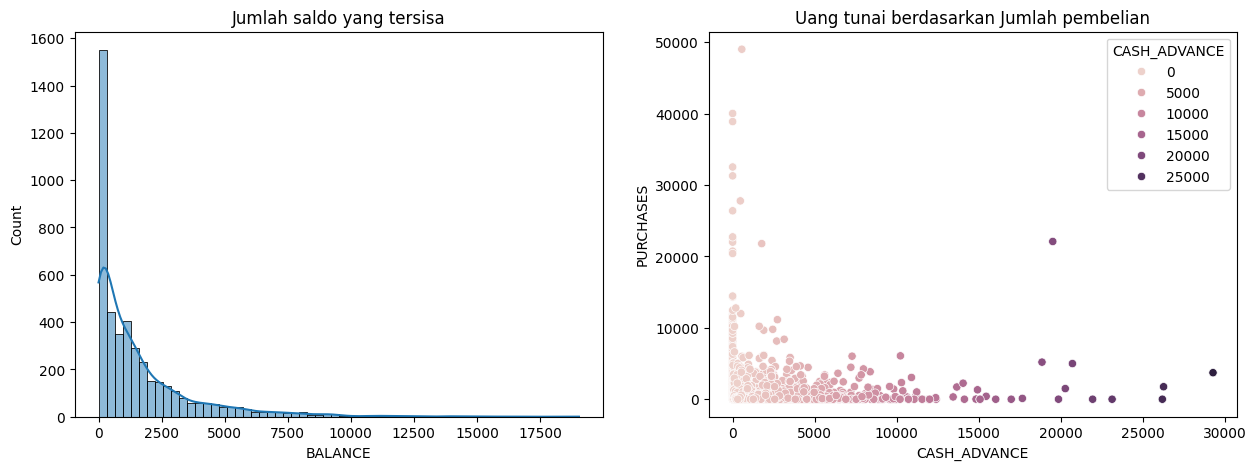

In [8]:
# Membuat Histogram dan Scatter Plot
# bikin kanvas
plt.figure(figsize=(15,5))                              #untuk bikin canvas, 15 itu panjangnya, 5 lebarnya

# Plot 1 taruh dikiri
plt.subplot(1, 2, 1)                                    #untuk bikin kolom 1 (1(untuk baris), 2(untuk kolom), 1(pilih kolom mana yang mau ditampilkan))
sns.histplot(df_1['BALANCE'],kde=True, bins=60, palette='muted')           #untuk bikin grafik, kde itu untuk bikin gari miringnya, binsnya itu banyak batangnya
plt.title('Jumlah saldo yang tersisa')                                      #judul grafik

# Plot 2 taruh dikanan
plt.subplot(1, 2, 2)                                    #untuk bikin kolom 2
sns.scatterplot(x='CASH_ADVANCE',y='PURCHASES',hue='CASH_ADVANCE',data=df_1)    #untuk bikin grafik
plt.title('Uang tunai berdasarkan Jumlah pembelian')

# tampilkan plot
plt.show

Dari hasil plot diatas dapat kita simpulkan bahwa :
- pada plot kiri jumlah saldo yang tersisa di akun pelanggan untuk melakukan pembelian lebih banyak yang 0. 

- pada plot kanan kesimpulannya yaitu untuk `CASH_ADVANCE` uang tunai di muka yang diberikan oleh pengguna hanya sedikit yang yang nominal diatas 25000.

<function matplotlib.pyplot.show(close=None, block=None)>

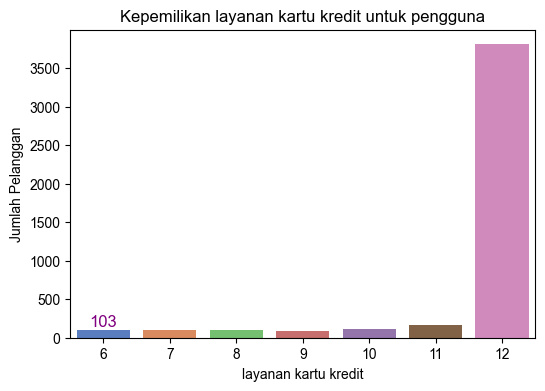

In [9]:
# Plot 3 
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=df_1["TENURE"], palette="muted")
sns.set(style="whitegrid")                                      # Opsi ini menambahkan grid pada plot
ax.bar_label(ax.containers[0], color="purple", fontsize=12)     # Menambahkan label di atas bar
plt.title("Kepemilikan layanan kartu kredit untuk pengguna")
plt.xlabel("layanan kartu kredit")                 # Mengganti ylabel menjadi xlabel
plt.ylabel("Jumlah Pelanggan")
plt.show

Dari plot diatas dapat kita simpulkan bahwa kepemilikan layanan kartu kredit bagi pengguna jauh lebih banyak yang menggunakan layanan kartu kredit 12.

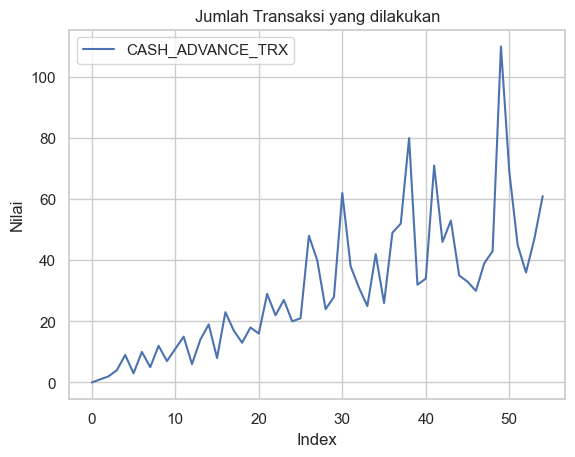

In [10]:
# Plot 4
# Data yang ada dalam kolom "nama_kolom" dan "nilai_unique"
nama_kolom = ["CASH_ADVANCE_TRX"]
nilai_unique = [[0, 1, 2, 4, 9, 3, 10, 5, 12, 7, 11, 15, 6, 14, 19, 8, 23, 17, 13, 18, 16, 29, 22, 27, 20, 21, 48, 40, 24, 28, 62, 38, 31, 25, 42, 26, 49, 52, 80, 32, 34, 71, 46, 53, 35, 33, 30, 39, 43, 110, 69, 45, 36, 47, 61],  # Contoh data untuk "CASH_ADVANCE_TRX"
]

# Membuat line chart untuk setiap kolom
for i in range(len(nama_kolom)):
    plt.plot(nilai_unique[i], label=nama_kolom[i])

# Menambahkan label pada sumbu x dan y
plt.xlabel('Index')
plt.ylabel('Nilai')
plt.title('Jumlah Transaksi yang dilakukan')

# Menampilkan legenda
plt.legend()

# Menampilkan line chart
plt.show()

Dari linechart diatas dapat kita simpulkan bahwa jumlah Transaksi yang dilakukan dengan 'Cash in Advanced' hasilnya seimbang, semakin banyak melakukan transaksi maka semakin besar juga nominalnya.

<function matplotlib.pyplot.show(close=None, block=None)>

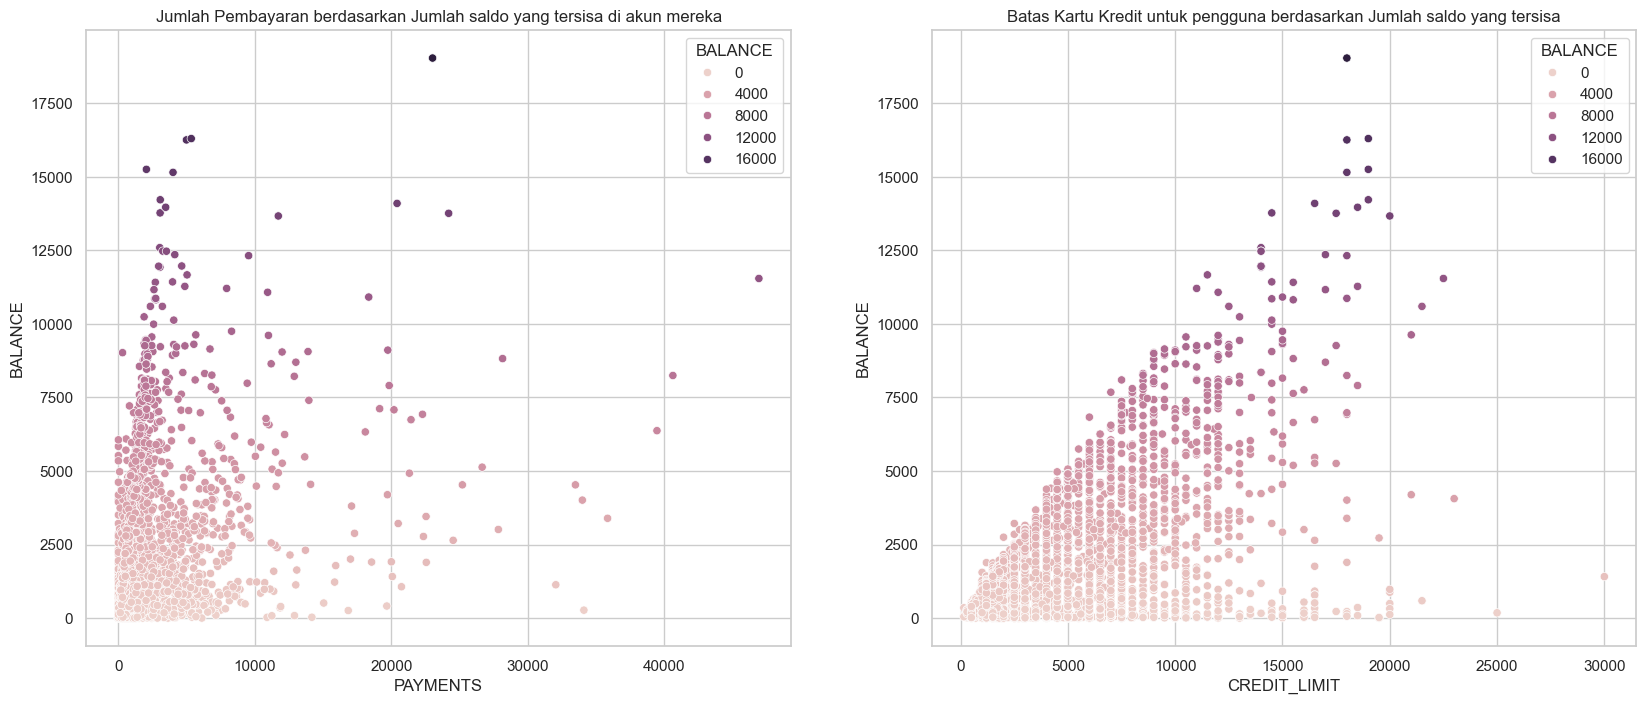

In [11]:
# Membuat Histogram dan Scatter Plot
# bikin kanvas
plt.figure(figsize=(20,8))                              #untuk bikin canvas, 15 itu panjangnya, 5 lebarnya

# Plot 5 taruh dikiri
plt.subplot(1, 2, 1)                                    #untuk bikin kolom 1 (1(untuk baris), 2(untuk kolom), 1(pilih kolom mana yang mau ditampilkan))
sns.scatterplot(x='PAYMENTS',y='BALANCE',hue='BALANCE',data=df_1)    #untuk bikin grafik
plt.title('Jumlah Pembayaran berdasarkan Jumlah saldo yang tersisa di akun mereka')                                      #judul grafik

# Plot 6 taruh dikanan
plt.subplot(1, 2, 2)                                    #untuk bikin kolom 2
sns.scatterplot(x='CREDIT_LIMIT',y='BALANCE',hue='BALANCE',data=df_1)    #untuk bikin grafik
plt.title('Batas Kartu Kredit untuk pengguna berdasarkan Jumlah saldo yang tersisa')

# tampilkan plot
plt.show

Dari hasil diatas dapat kita simpulkan bahwa:
- pada plot kiri `PAYMENTS` jumlah Pembayaran yang dilakukan oleh pengguna berdasarkan `BALANCE` Jumlah saldo yang tersisa di akun mereka hasilnya hanya sedikit yang meliki saldo lebih dari 15000.

- pada plot kanan `CREDIT_LIMIT` Batas Kartu Kredit untuk pengguna berdasarkan `BALANCE` Jumlah saldo yang tersisa di akun mereka hasilnya lebih banyak pengguna dengan batas kartu kredit dibawah limit 10000.  

---

# Feature Engineering

Pada bagian ini kita akan melakukan proses penyiapan data untuk memproses pelatihan model, melakukan handling missing value, membuat sample data inf, outliers handling, melakukan caping, melakukan cek cardinality, melakukan feature scalling, dan feature encoding.

### 1. Handling Missing Values

In [12]:
# Memeriksa nilai yang hilang dalam setiap kolom
missing_values = df_1.isnull().sum()

# Menampilkan jumlah nilai yang hilang dalam setiap kolom
missing_values

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Pada kolom `CREDIT_LIMIT` dan kolom `MINIMUM_PAYMENTS` terdapat missing value, kita tampilkan dan analisa terlebih dahulu dimana saja letak missing valuenya. Kita handling missing valuenya terlebih dahulu, lalu kita drop diawal sebelum kita membuat sample data.

In [13]:
# Menampilkan missing values
pd.set_option('display.max_columns', None)
df_1[df_1['CREDIT_LIMIT'].isnull()]

CUST_ID    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
3843     4956  18.400472           0.166667        0.0               0.0   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
3843                     0.0    186.853063                  0.0   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
3843                         0.0                               0.0   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
3843                0.166667                 1              0           NaN   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
3843  9.040017         14.418723               0.0       6

Terdapat 1 missing value di kolom `CREDIT_LIMIT` pada baris ke 3843.

In [14]:
# Menampilkan missing values
pd.set_option('display.max_columns', None)
df_1[df_1['MINIMUM_PAYMENTS'].isnull()]

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0         788    16.581535           0.125000     200.00              0.00   
2        2322     1.979916           0.125000      80.00             80.00   
6        4360  2730.843802           1.000000    2900.00           2900.00   
8        5884    18.885677           0.375000      57.00             57.00   
27       1830     0.000000           0.000000      66.75              0.00   
...       ...          ...                ...        ...               ...   
4049     7492  2242.311686           1.000000     437.00             97.00   
4087     4290  1948.434315           1.000000     324.30            324.30   
4091     5468  4618.091584           1.000000     541.68            541.68   
4144     4234    27.716642           0.100000       0.00              0.00   
4293     8058   116.172752           0.111111       0.00              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     200.00      0.000000             0.125000   
2                       0.00      0.000000             0.125000   
6                       0.00      0.000000             0.125000   
8                       0.00      0.000000             0.125000   
27                     66.75      0.000000             0.250000   
...                      ...           ...                  ...   
4049                  340.00    184.648692             0.333333   
4087                    0.00   1468.083560             0.166667   
4091                    0.00   3580.753362             0.166667   
4144                    0.00    480.104401             0.000000   
4293                    0.00   1867.994674             0.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.125000   
2                       0.125000                          0.000000   
6                       0.125000                          0.000000   
8                       0.125000                          0.000000   
27                      0.000000                          0.250000   
...                          ...                               ...   
4049                    0.083333                          0.333333   
4087                    0.166667                          0.000000   
4091                    0.166667                          0.000000   
4144                    0.000000                          0.000000   
4293                    0.000000                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              2        1200.0   
2                   0.000000                 0              1        1500.0   
6                   0.000000                 0              1        2900.0   
8                   0.000000                 0              1        1500.0   
27                  0.000000                 0              3        4000.0   
...                      ...               ...            ...           ...   
4049                0.166667                 2              5        2400.0   
4087                0.166667                 4              4        5000.0   
4091                0.166667                 2              2        8500.0   
4144                0.100000                 1              0        5000.0   
4293                0.111111                 6              0        3000.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0          0.0               NaN               0.0       8  
2          0.0               NaN               0.0       8  
6          0.0               NaN               0.0       8  
8          0.0               NaN               0.0       8  
27         0.0               NaN               0.0      12  
...        ...               ...               ...     ...  
4049       0.0               NaN               

Terdapat missing value di kolom `MINIMUM_PAYMENTS` sebanyak 158 baris.

In [15]:
# Drop baris yang memiliki missing value
df_1.dropna(axis=0,inplace=True)
df_1.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

Alasan kita menggunakan (.dropna) yaitu karena datanya banyak dan untuk memudahkan kita dalam mengolah data selanjutnya. Setelah kita dropna maka kita mendapatkan hasil data yang sudah bersih dan tidak memiliki missing value. 

### 2. Membuat sampel data inference

In [16]:
# menyimpan 1 data random dari data asli untuk digunakan sebagai data inference ke dalam variabel data_inf
data_inf = df_1.sample(1, random_state=42)

# menghapus data inference dari df
df_1.drop(data_inf.index, inplace=True)

# melakukan reset index untuk data_inf dan df
df_1.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

# Export data Inference
data_inf.to_csv('data_inf.csv',index=False)

Untuk mendrop satu baris dari keseluruhan data yang nanti akan kita jadikan bahan untuk prediksi.

### 3. Cek Cardinality

Langkah selanjutnya adalah kita cek cardinality.

In [17]:
# Cek Cardinality
pd.set_option('display.max_colwidth', None)
values = []
for col in df_1.columns:
    values.append([col, df_1[col].nunique(), df_1[col].unique()])

pd.DataFrame(values, columns=['nama_kolom', 'jumlah_unique', 'nilai_unique'])

nama_kolom  jumlah_unique  \
0                            CUST_ID           4315   
1                            BALANCE           4312   
2                  BALANCE_FREQUENCY             38   
3                          PURCHASES           3118   
4                   ONEOFF_PURCHASES           2022   
5             INSTALLMENTS_PURCHASES           2292   
6                       CASH_ADVANCE           2090   
7                PURCHASES_FREQUENCY             47   
8         ONEOFF_PURCHASES_FREQUENCY             44   
9   PURCHASES_INSTALLMENTS_FREQUENCY             47   
10            CASH_ADVANCE_FREQUENCY             46   
11                  CASH_ADVANCE_TRX             55   
12                     PURCHASES_TRX            147   
13                      CREDIT_LIMIT            151   
14                          PAYMENTS           4315   
15                  MINIMUM_PAYMENTS           4315   
16                  PRC_FULL_PAYMENT             47   
17                            TENURE              7   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      nilai_unique  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [1902, 3426, 3976, 4266, 4680, 24, 172, 190, 206, 374, 394, 422, 540, 570, 652, 936, 966, 1060, 1090, 1250, 1432, 1434, 1454, 1882, 1908, 2012, 2062, 2116, 2176, 2256, 2326, 2418, 2422, 2448, 2480, 2512, 2556, 2682, 2684, 2802, 2814, 2846, 2946, 3086, 3096, 3294, 3420, 3612, 3756, 3814, 4014, 4020, 4160, 4182, 4192, 4350, 4414, 4498, 4750, 4772, 4896, 4922, 4972, 5002, 5010, 5084, 5114, 5246, 5452, 5588, 5650, 5668, 5758, 5828, 5934, 6026, 6062, 6182, 6258, 6272, 6294, 6344, 6394, 6416, 6474, 6908, 6996, 7050, 7188, 7226, 7234, 7310, 7458, 7460, 7486, 7490, 7526, 7630, 7650, 8030, ...]  
1                                                                                         [943.584041, 461.45572, 1053.59473, 2237.238086, 424.994385, 0.004816, 867.728471, 41.25567, 857.767403, 5850.1729, 545.819208, 64.080909, 10.286805, 576.890374, 1391.33075, 1.155609, 76.096025, 1779.796624, 1610.040203, 1557.750089, 330.273411, 1151.703776, 3144.690403, 154.641707, 13.362018, 7.634737, 82.470475, 73.10055, 623.095349, 32.612016, 31.744161, 13.925681, 75.647479, 11

Dari hasil diatas dapat kita simpulkan bahwa data merupakan data low cardinality karena dia memiliki sedikit categorical, jadi kita tidak perlu melakukan cardinality.

### 4. Outliers Handling

Saya melakukan outliers handling untuk menghandle outliers dengan menggunakan metode caping.

#### A. Check distribusi

Pada proses kali ini kita akan melakukan check distribusi pada kategori numerical untuk mengetahui mana yang skewness dan mana yang distribusinya normal.

pada bagian ini kita akan melakukan :
- Menentukan data distribusi apakah termasuk normal atau tidak normal
- Menampilkan distribusi melalui diagram/grafik
- Memastikan nilai upper wounder dan lower bounder
- Menghandling fitur/kolom yang memiliki outlier

In [18]:
# cek apakah distribusinya normal atau tidak
print('Distribution of column `CUST_ID`                             : ', df_1['CUST_ID'].skew())
print('Distribution of column `BALANCE`                             : ', df_1['BALANCE'].skew())
print('Distribution of column `BALANCE_FREQUENCY`                   : ', df_1['BALANCE_FREQUENCY'].skew())
print('Distribution of column `PURCHASES`                           : ', df_1['PURCHASES'].skew())
print('Distribution of column `ONEOFF_PURCHASES`                    : ', df_1['ONEOFF_PURCHASES'].skew())
print('Distribution of column `INSTALLMENTS_PURCHASES`              : ', df_1['INSTALLMENTS_PURCHASES'].skew())
print('Distribution of column `CASH_ADVANCE`                        : ', df_1['CASH_ADVANCE'].skew())
print('Distribution of column `PURCHASES_FREQUENCY`                 : ', df_1['PURCHASES_FREQUENCY'].skew())
print('Distribution of column `ONEOFF_PURCHASES_FREQUENCY`          : ', df_1['ONEOFF_PURCHASES_FREQUENCY'].skew())
print('Distribution of column `PURCHASES_INSTALLMENTS_FREQUENCY`    : ', df_1['PURCHASES_INSTALLMENTS_FREQUENCY'].skew())
print('Distribution of column `CASH_ADVANCE_FREQUENCY`              : ', df_1['CASH_ADVANCE_FREQUENCY'].skew())
print('Distribution of column `CASH_ADVANCE_TRX`                    : ', df_1['CASH_ADVANCE_TRX'].skew())
print('Distribution of column `PURCHASES_TRX`                       : ', df_1['PURCHASES_TRX'].skew())
print('Distribution of column `CREDIT_LIMIT`                        : ', df_1['CREDIT_LIMIT'].skew())
print('Distribution of column `PAYMENTS`                            : ', df_1['PAYMENTS'].skew())
print('Distribution of column `MINIMUM_PAYMENTS`                    : ', df_1['MINIMUM_PAYMENTS'].skew())
print('Distribution of column `PRC_FULL_PAYMENT`                    : ', df_1['PRC_FULL_PAYMENT'].skew())
print('Distribution of column `TENURE`                              : ', df_1['TENURE'].skew())


Distribution of column `CUST_ID`                             :  0.00018190213914652957
Distribution of column `BALANCE`                             :  2.441208848799248
Distribution of column `BALANCE_FREQUENCY`                   :  -2.0827907782957533
Distribution of column `PURCHASES`                           :  8.901455893295639
Distribution of column `ONEOFF_PURCHASES`                    :  10.04441964905694
Distribution of column `INSTALLMENTS_PURCHASES`              :  8.029652070553782
Distribution of column `CASH_ADVANCE`                        :  4.712926645687818
Distribution of column `PURCHASES_FREQUENCY`                 :  0.03518808443706796
Distribution of column `ONEOFF_PURCHASES_FREQUENCY`          :  1.4941501668072763
Distribution of column `PURCHASES_INSTALLMENTS_FREQUENCY`    :  0.4862060678745964
Distribution of column `CASH_ADVANCE_FREQUENCY`              :  1.790183054784538
Distribution of column `CASH_ADVANCE_TRX`                    :  4.724037874984341
Distr

Dapat kita simpulkan bahwa :
1. Kolom yang termasuk skew
- `BALANCE` , `BALANCE_FREQUENCY` , `PURCHASES` , `ONEOFF_PURCHASES` , `INSTALLMENTS_PURCHASES` , `CASH_ADVANCE` , `ONEOFF_PURCHASES_FREQUENCY` , `CASH_ADVANCE_FREQUENCY` , `CASH_ADVANCE_TRX` , `PURCHASES_TRX` , `CREDIT_LIMIT` , `PAYMENTS` , `MINIMUM_PAYMENTS` , `PRC_FULL_PAYMENT` dan `TENURE` termasuk extreme skew (karena hasil nilainya => 1/-1) yang berati memiliki outlier
2. yang termasuk normal
- kolom `CUST_ID`, `PURCHASES_FREQUENCY` dan `PURCHASES_INSTALLMENTS_FREQUENCY` merupakan normal distribution (karena termasuk kolom categorical).

#### *- Menampilkan diagram distribusi* 

In [19]:
# membuat histogram dan boxplot dengan menggunakan kerangka data (df_1) dan variabel yang diinginkan sebagai argumen.

def diagnostic_plots(df_1, variable):
    # Tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_1[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_1[variable])
    plt.title('Boxplot')

    plt.show()

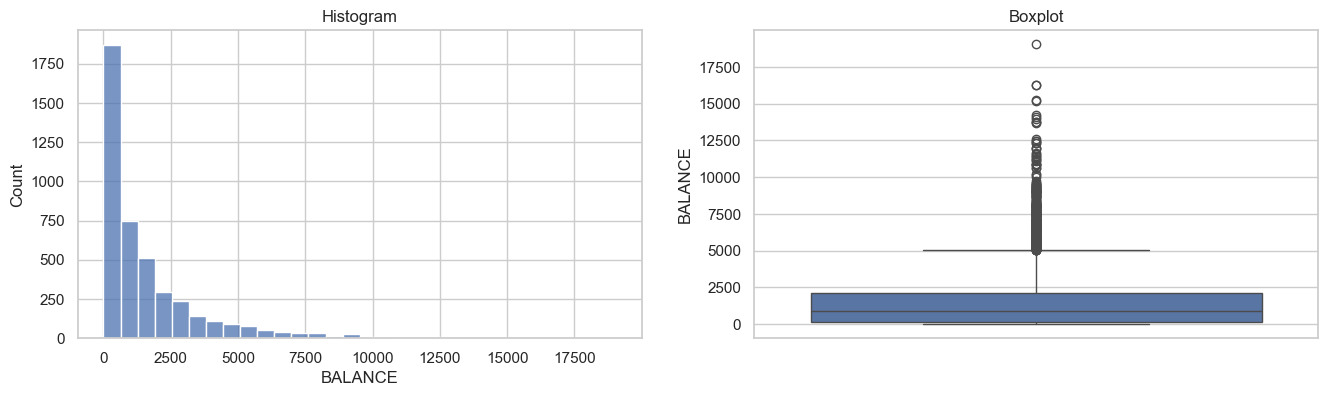

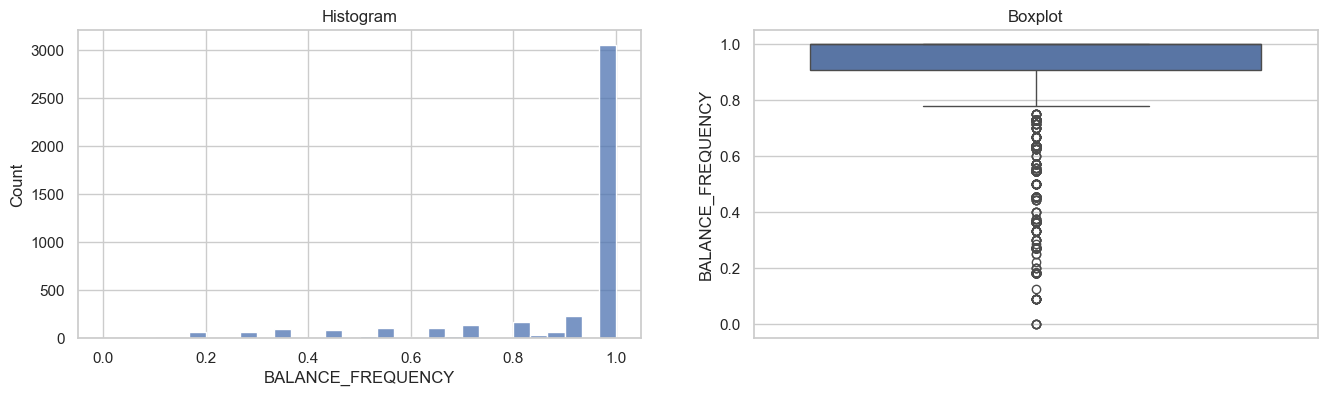

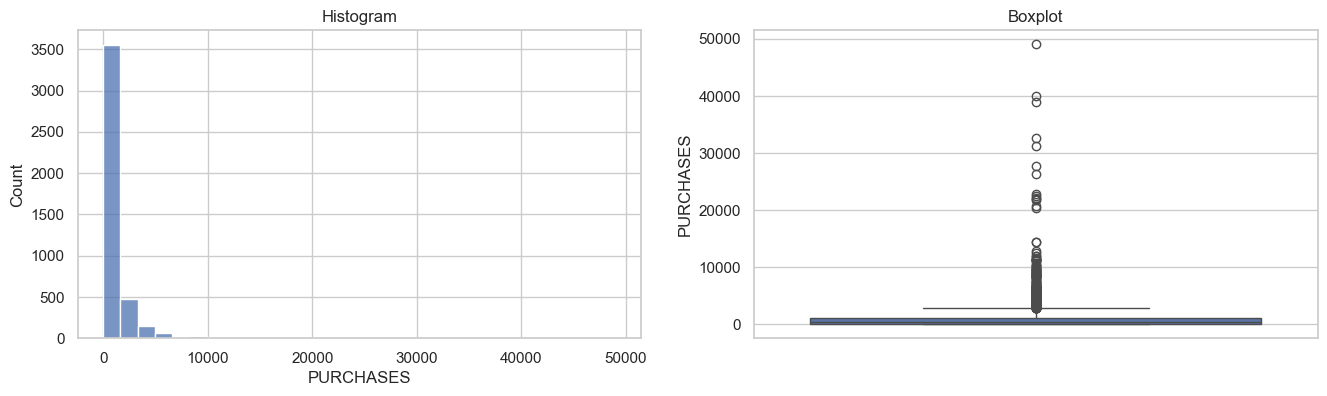

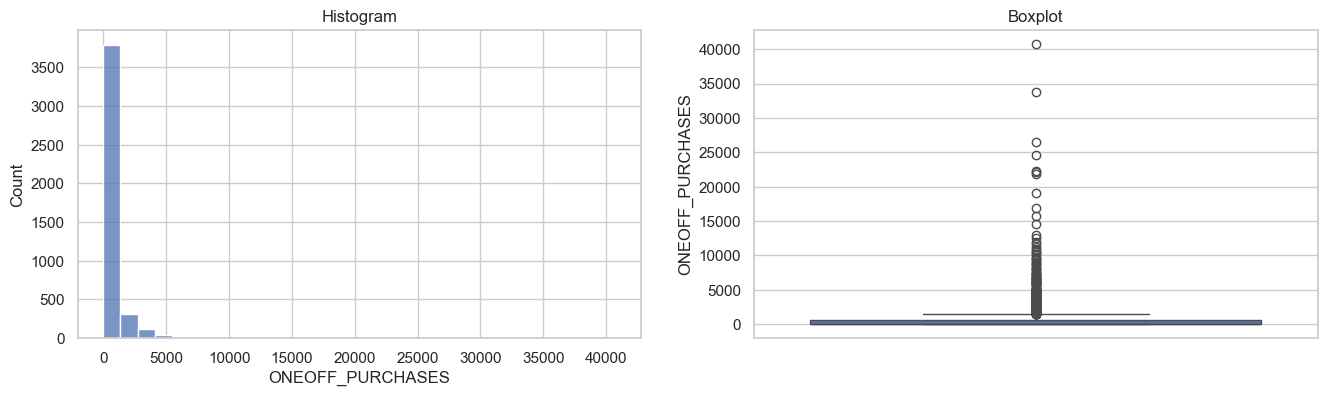

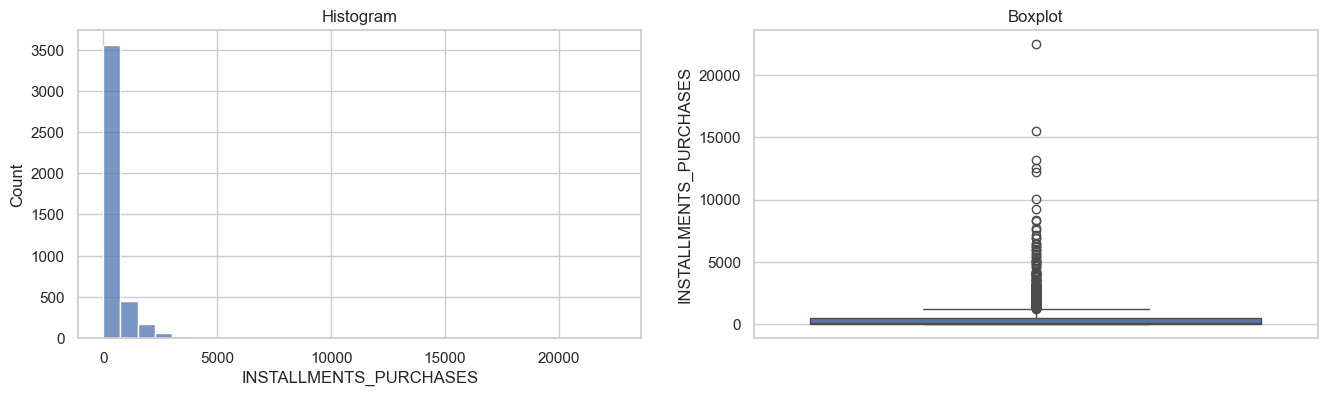

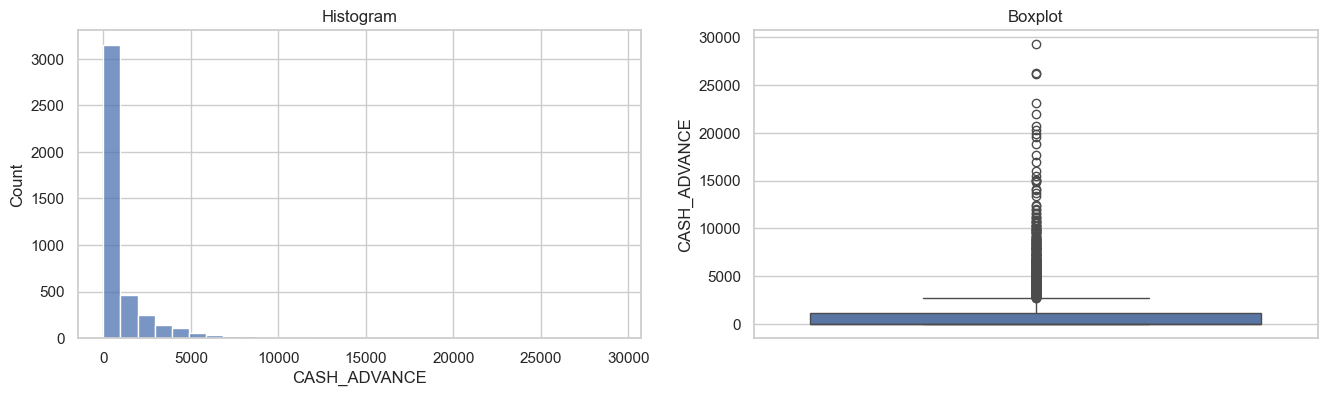

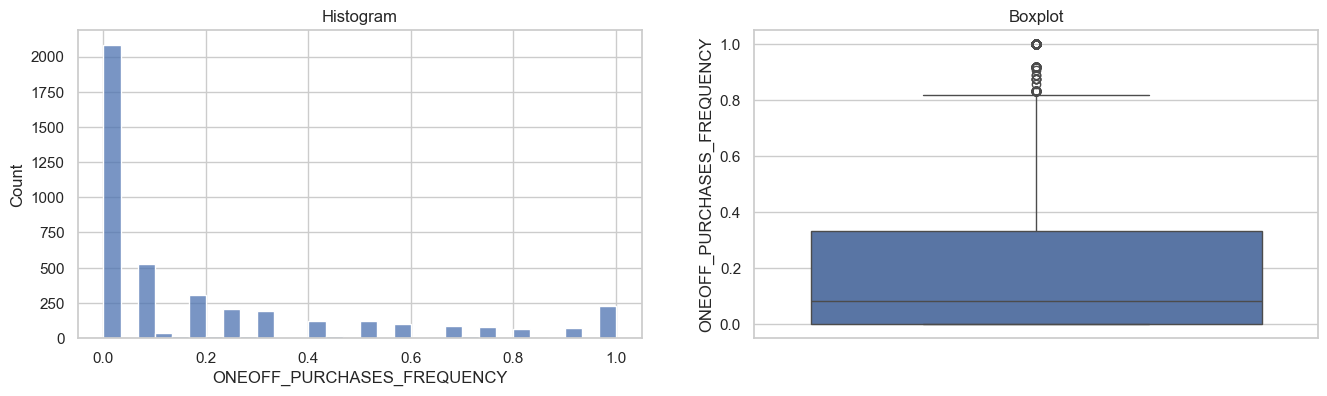

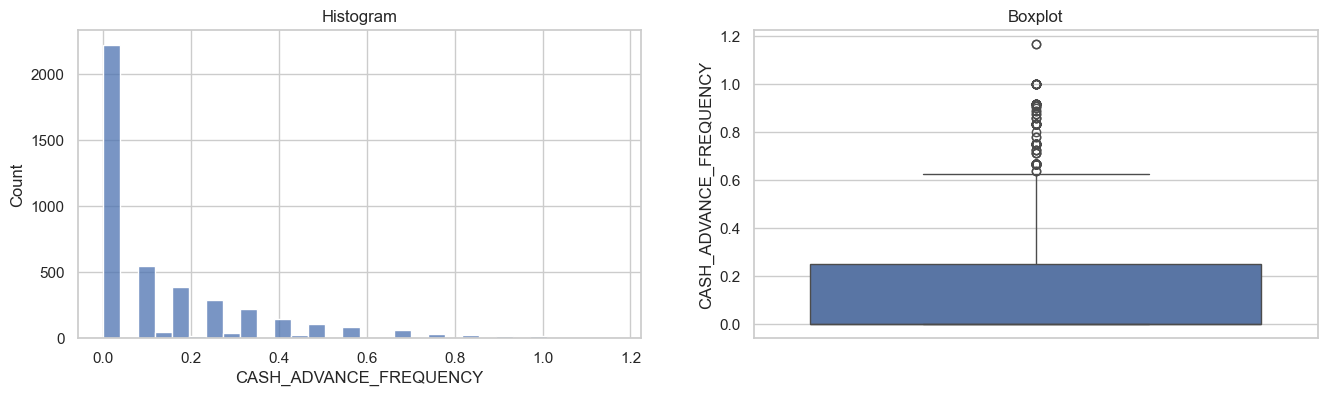

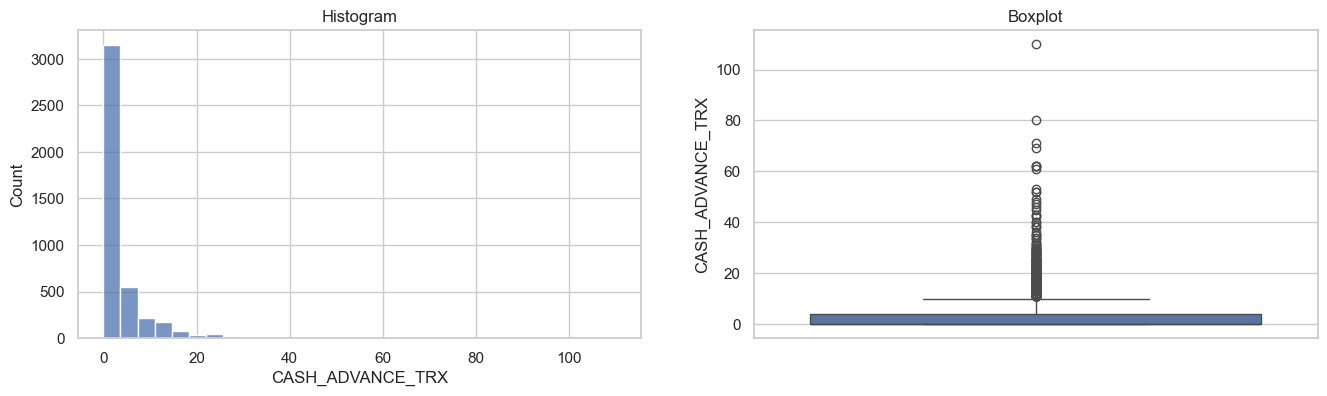

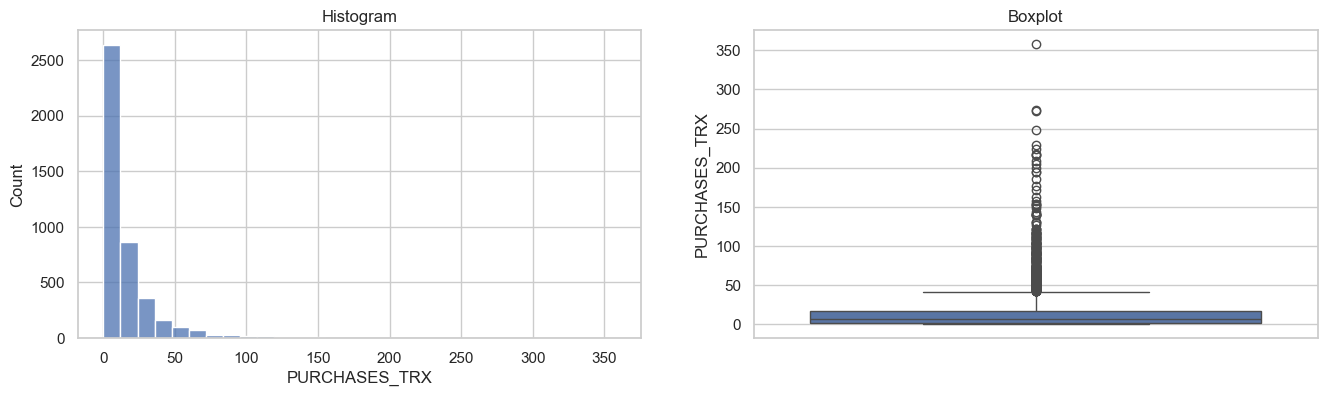

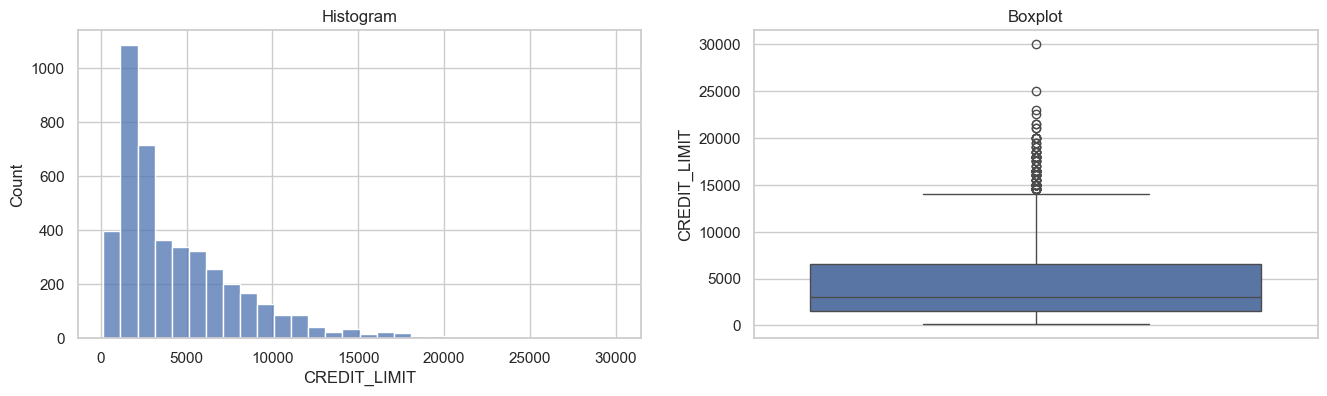

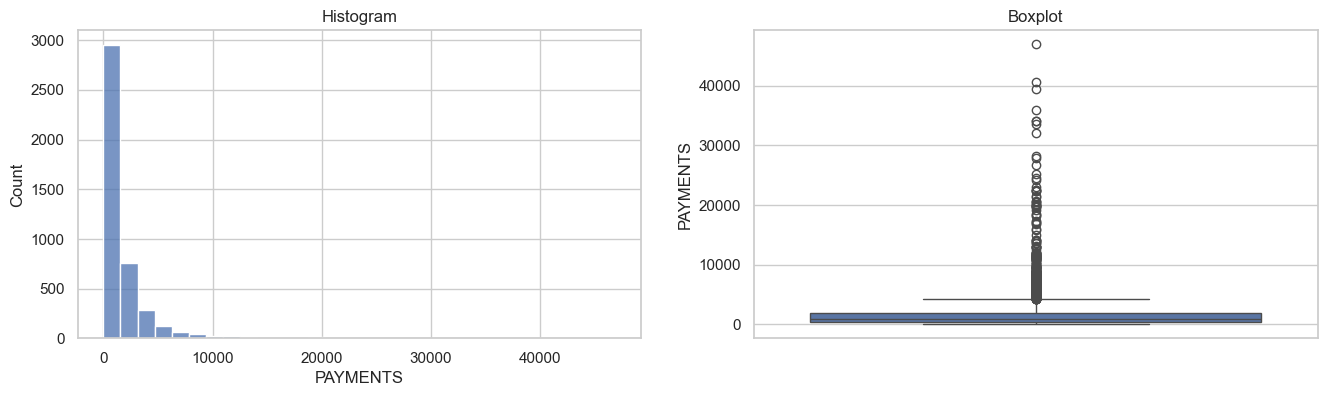

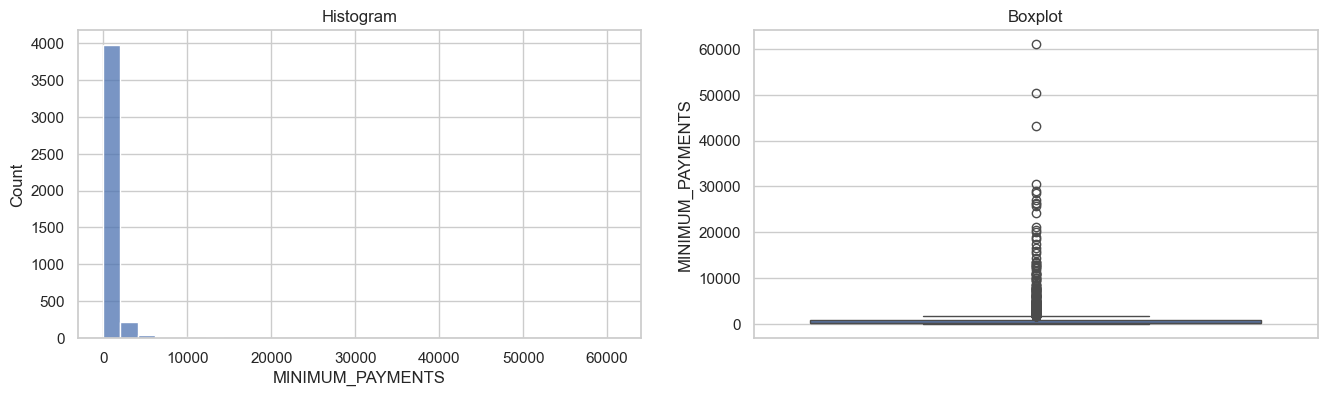

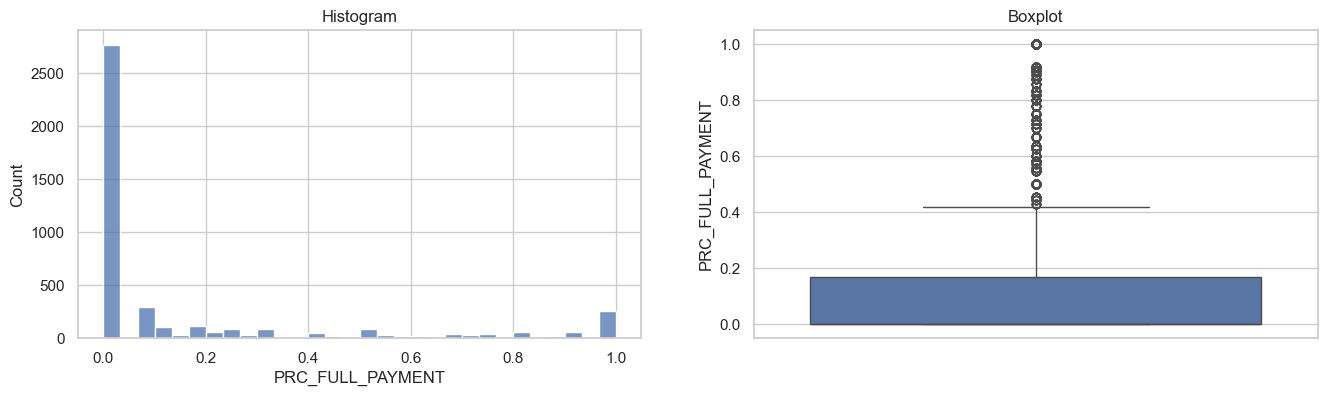

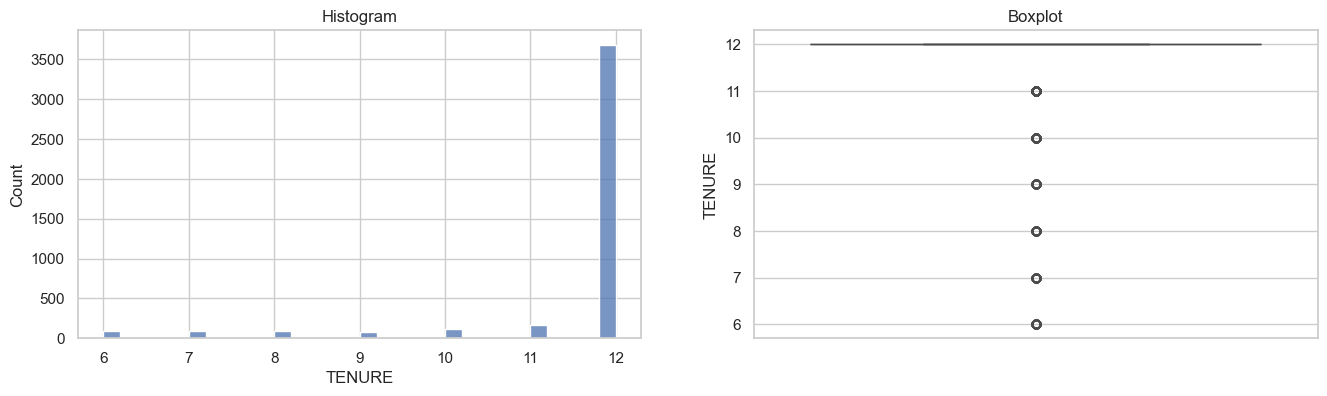

In [20]:
# visualisasi skewed distribution menggunakan boxplot
columns_to_visualize = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
                        'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','ONEOFF_PURCHASES_FREQUENCY',
                        'CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 
                        'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
for variable in columns_to_visualize:
    diagnostic_plots(df_1, variable)

Bisa kita lihat dari diagram diatas terdapat outlier/distribusi skew pada kolom  `BALANCE`, `BALANCE_FREQUENCY`, `PURCHASES`, `ONEOFF_PURCHASES`,`INSTALLMENTS_PURCHASES`, `CASH_ADVANCE`,`ONEOFF_PURCHASES_FREQUENCY`,`CASH_ADVANCE_FREQUENCY`,`CASH_ADVANCE_TRX`, `PURCHASES_TRX`, `CREDIT_LIMIT`, `PAYMENTS`, `MINIMUM_PAYMENTS`, `PRC_FULL_PAYMENT`,  dan `TENURE`.

#### *- Memastikan nilai upper bounder dan lower bounder*

Pada tahap ini kita akan memastikan nilai upper bound dan lower bound untuk menjaga validitas data kita, menghindari kesalahan perhitungan pada data, dan mematuhi batasan yang ada dalam konteks tertentu. Dalam hal ini kita periksa apakah data kita sudah di antara upper bounder atau belum.

In [21]:
# Berfungsi untuk mencari batas atas dan bawah variabel yang terdistribusi normal
def find_normal_boundaries(df_1, variable):
    # Hitung batas luar yang merupakan outlier untuk distribusi Gaussian
    upper_boundary = df_1[variable].mean() + 3 * df_1[variable].std()
    lower_boundary = df_1[variable].mean() - 3 * df_1[variable].std()

    return upper_boundary, lower_boundary

In [22]:
numeric_data = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
                'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','ONEOFF_PURCHASES_FREQUENCY',
                'CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 
                'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

for i in numeric_data:
    # Kita hitung batas luar yang merupakan outlier untuk distribusi yang miring
    IQR = df_1[i].quantile(0.75) - df_1[i].quantile(0.25)
    # Jarak yang dilewati sebagai argumen, memberi kita pilihan untuk memperkirakan 1,5 kali atau 3 kali IQR untuk menghitung batasannya.
    lower_boundary_distance = df_1[i].quantile(0.25) - (IQR * 1.5)
    upper_boundary_distance = df_1[i].quantile(0.75) + (IQR * 1.5)

    print(f'upper boundary for {[i]} : {upper_boundary_distance}')
    print(f'lower boundary for {[i]} : {lower_boundary_distance}')
    print("---------------------------------------------------------")

upper boundary for ['BALANCE'] : 5050.37924
lower boundary for ['BALANCE'] : -2785.794688
---------------------------------------------------------
upper boundary for ['BALANCE_FREQUENCY'] : 1.1363635
lower boundary for ['BALANCE_FREQUENCY'] : 0.7727275
---------------------------------------------------------
upper boundary for ['PURCHASES'] : 2807.9625
lower boundary for ['PURCHASES'] : -1613.3775
---------------------------------------------------------
upper boundary for ['ONEOFF_PURCHASES'] : 1500.0
lower boundary for ['ONEOFF_PURCHASES'] : -900.0
---------------------------------------------------------
upper boundary for ['INSTALLMENTS_PURCHASES'] : 1246.7875
lower boundary for ['INSTALLMENTS_PURCHASES'] : -748.0725
---------------------------------------------------------
upper boundary for ['CASH_ADVANCE'] : 2772.3511799999997
lower boundary for ['CASH_ADVANCE'] : -1663.4107079999999
---------------------------------------------------------
upper boundary for ['ONEOFF_PURCHASE

#### B. Melakukan Capping

Karena pada dataset ini terdapat 2 tipe distribusi, yaitu distribusi normal dan distribusi skewed, maka censoring akan dilakukan sebanyak 2 kali.

In [23]:
# First, capping the normal distribution

categorical_data = ['CUST_ID', 'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']

winsoriser_categorical_data = Winsorizer(capping_method='gaussian',
                            tail='both',
                            fold=3,
                            variables=categorical_data,
                            missing_values='ignore')

df_1_capped = winsoriser_categorical_data.fit_transform(df_1)

# Tampilkan skewness
print(f"Before: {df_1[categorical_data].skew()}")
print(f"After: {df_1_capped[categorical_data].skew()}")

Before: CUST_ID                             0.000182
PURCHASES_FREQUENCY                 0.035188
PURCHASES_INSTALLMENTS_FREQUENCY    0.486206
dtype: float64
After: CUST_ID                             0.000182
PURCHASES_FREQUENCY                 0.035188
PURCHASES_INSTALLMENTS_FREQUENCY    0.486206
dtype: float64


Hasil before dan afternya sama dikarenakan kolomnya termasuk normal.

Kita akan melakukan remove pada kolom `Tenure` dikarenakan kolom tersebut termasuk low variant.

In [24]:
numeric_data = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
                'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','ONEOFF_PURCHASES_FREQUENCY',
                'CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 
                'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

numeric_data.remove('TENURE')
winsoriser = Winsorizer(capping_method='iqr', tail='both', fold=3, variables=numeric_data)
df_1_capped = winsoriser.fit_transform(df_1)

Setelah kita remove langkah selanjutnya kita caping pada kolom yang numerik.

                            Skewness Before Capping  Skewness After Capping
BALANCE                                    2.441209                1.755491
BALANCE_FREQUENCY                         -2.082791               -1.432196
PURCHASES                                  8.901456                1.797270
ONEOFF_PURCHASES                          10.044420                1.722649
INSTALLMENTS_PURCHASES                     8.029652                1.769329
CASH_ADVANCE                               4.712927                1.710161
ONEOFF_PURCHASES_FREQUENCY                 1.494150                1.494150
CASH_ADVANCE_FREQUENCY                     1.790183                1.775140
CASH_ADVANCE_TRX                           4.724038                1.766941
PURCHASES_TRX                              4.429524                1.742610
CREDIT_LIMIT                               1.525055                1.467873
PAYMENTS                                   5.986809                1.747981
MINIMUM_PAYM

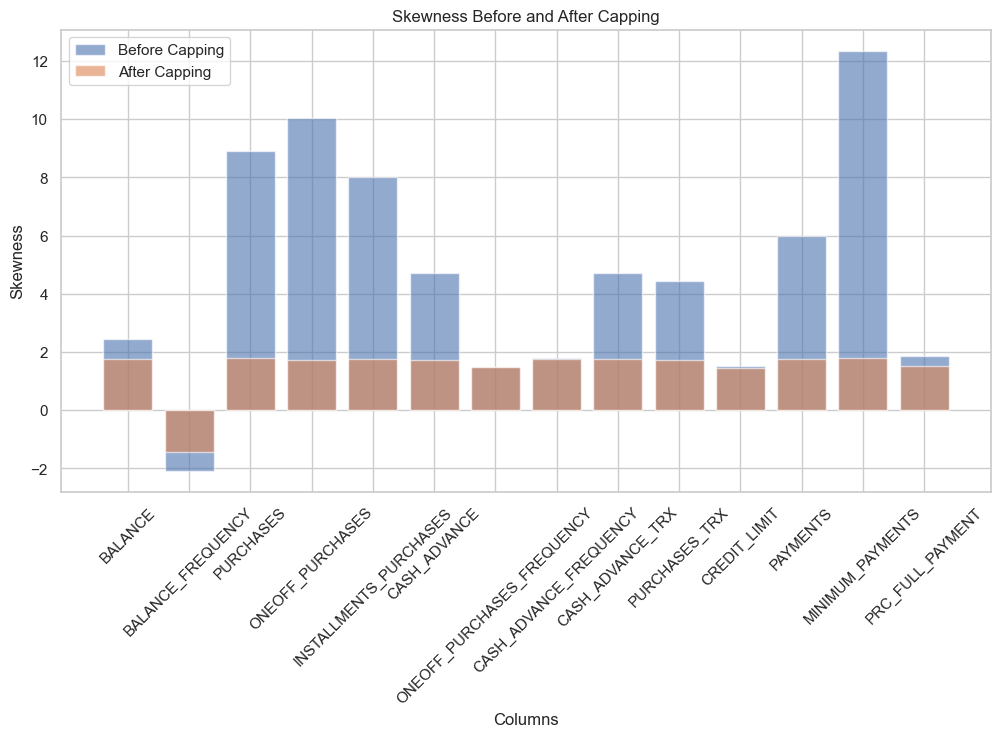

In [25]:
# Capping skewed distribution
numeric_data = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
                'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','ONEOFF_PURCHASES_FREQUENCY',
                'CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 
                'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

# Create a Winsorizer instance
winsoriser = Winsorizer(capping_method='iqr', 
                        tail='both', 
                        fold=3, 
                        variables=numeric_data)

# Fit and transform your dataset
df_1_capped = winsoriser.fit_transform(df_1)

# Calculate skewness before and after capping
skew_before = df_1[numeric_data].skew()
skew_after = df_1_capped[numeric_data].skew()

# Create a DataFrame to display skewness values
skewness_comparison = pd.DataFrame({'Skewness Before Capping': skew_before, 'Skewness After Capping': skew_after})

# Display the skewness comparison table
print(skewness_comparison)

# Visualize the skewness values before and after capping
plt.figure(figsize=(12, 6))
plt.bar(skewness_comparison.index, skewness_comparison['Skewness Before Capping'], label='Before Capping', alpha=0.6)
plt.bar(skewness_comparison.index, skewness_comparison['Skewness After Capping'], label='After Capping', alpha=0.6)
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.title('Skewness Before and After Capping')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Bisa kita lihat dari hasil analisis diatas, dari sebelumnya tinggi menjadi sesudahnya rendah, yang dimana capping ini berfungsi untuk meringankan machine learning dalam memprogres datasetnya. Untuk lebih jelasnya bisa kita lihat pada diagramnya.

distance - Sebelum Capping


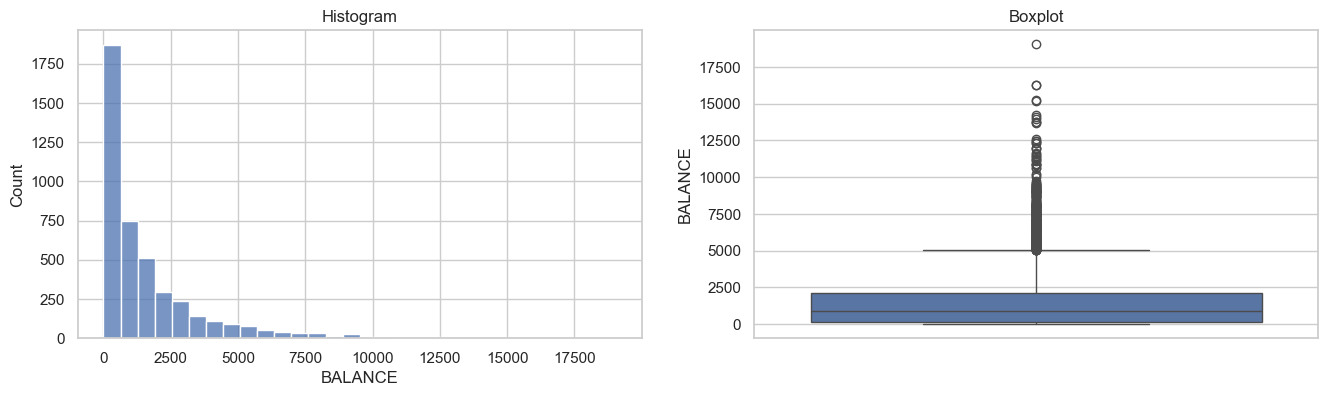


distance - Sesudah Capping


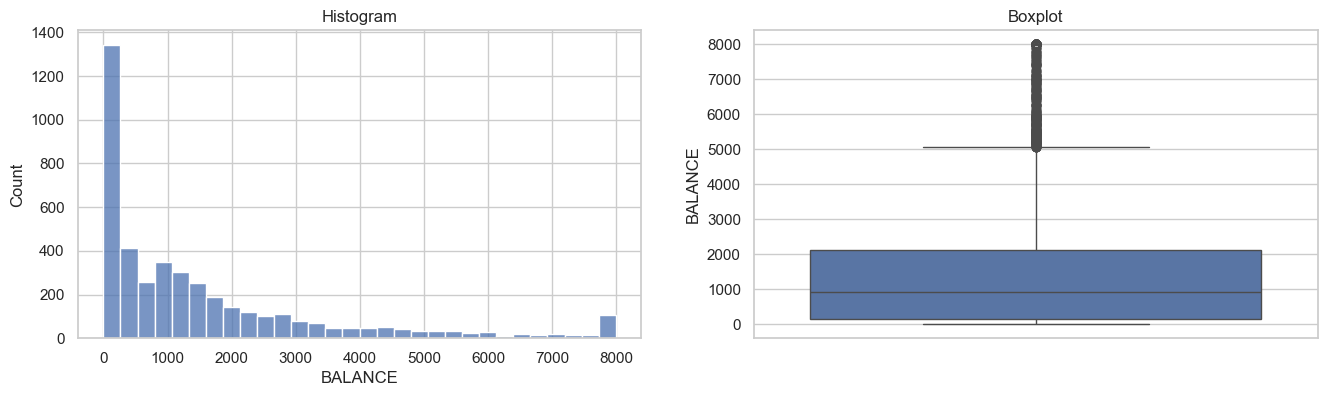

In [26]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'BALANCE')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'BALANCE')

distance - Sebelum Capping


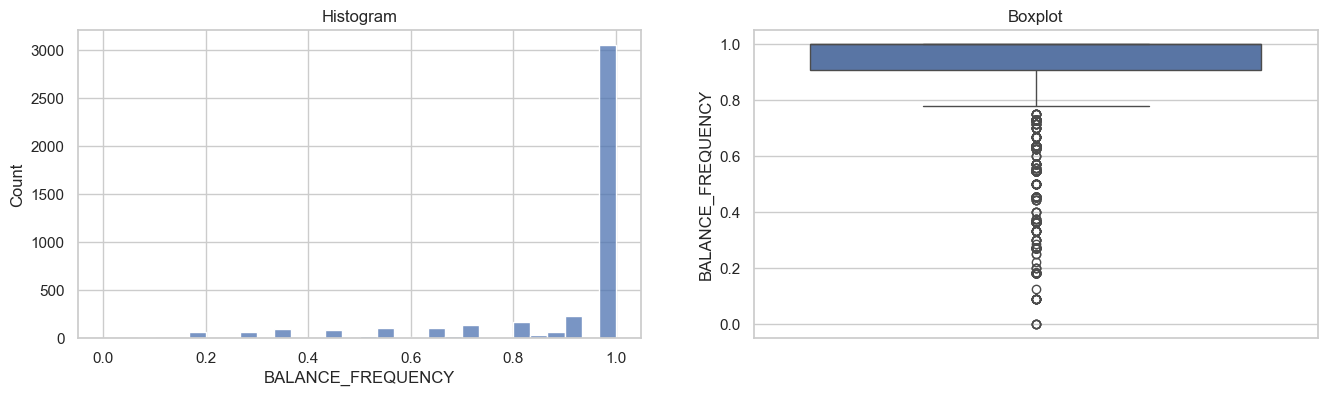


distance - Sesudah Capping


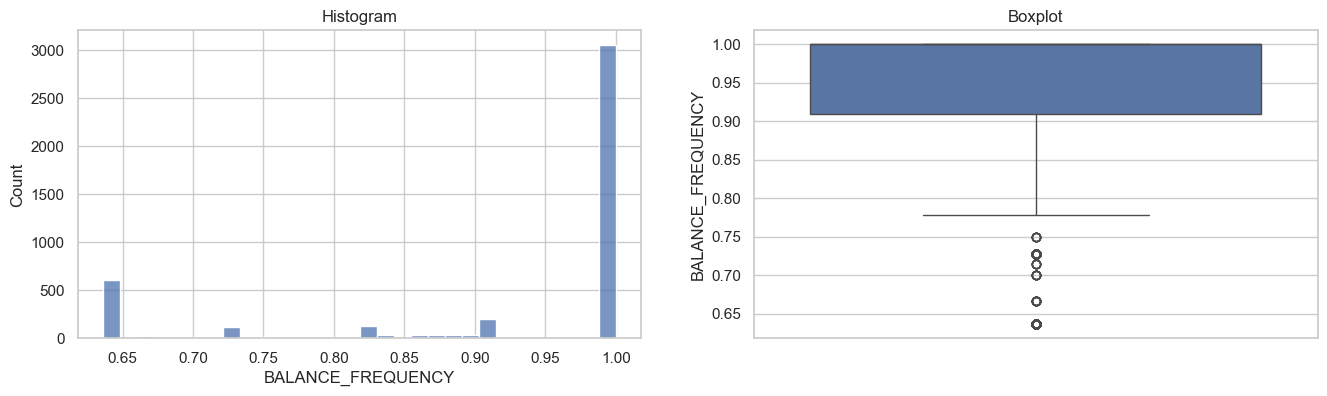

In [27]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'BALANCE_FREQUENCY')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'BALANCE_FREQUENCY')

distance - Sebelum Capping


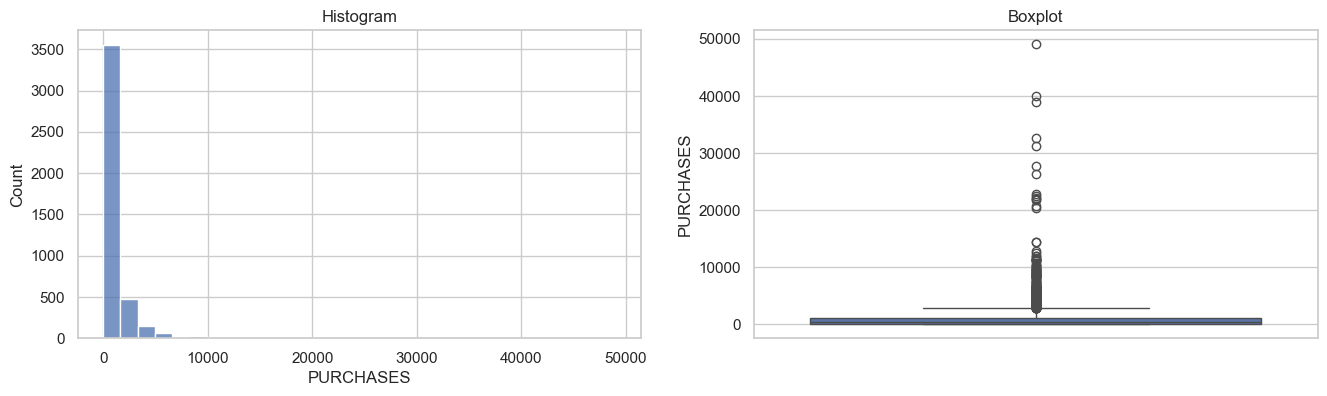


distance - Sesudah Capping


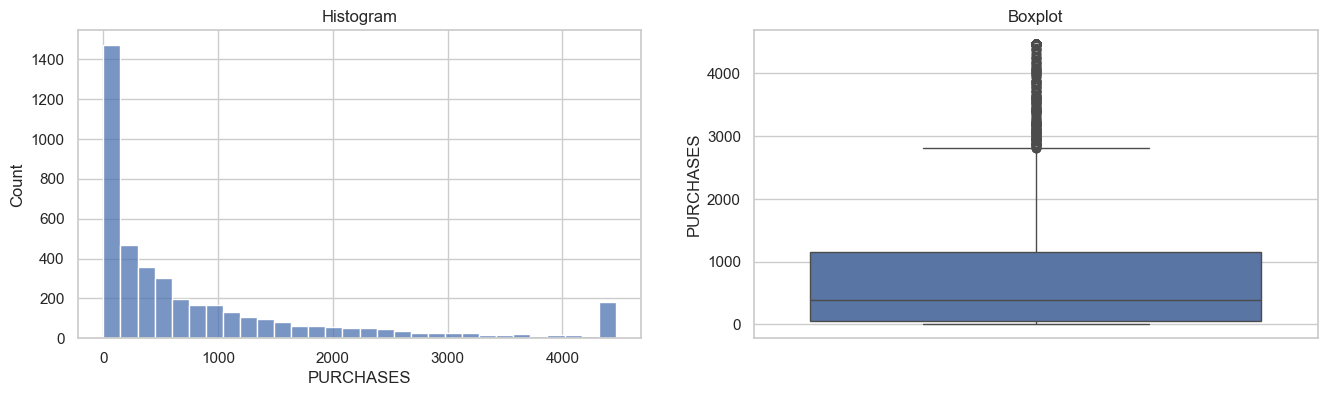

In [28]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'PURCHASES')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'PURCHASES')

distance - Sebelum Capping


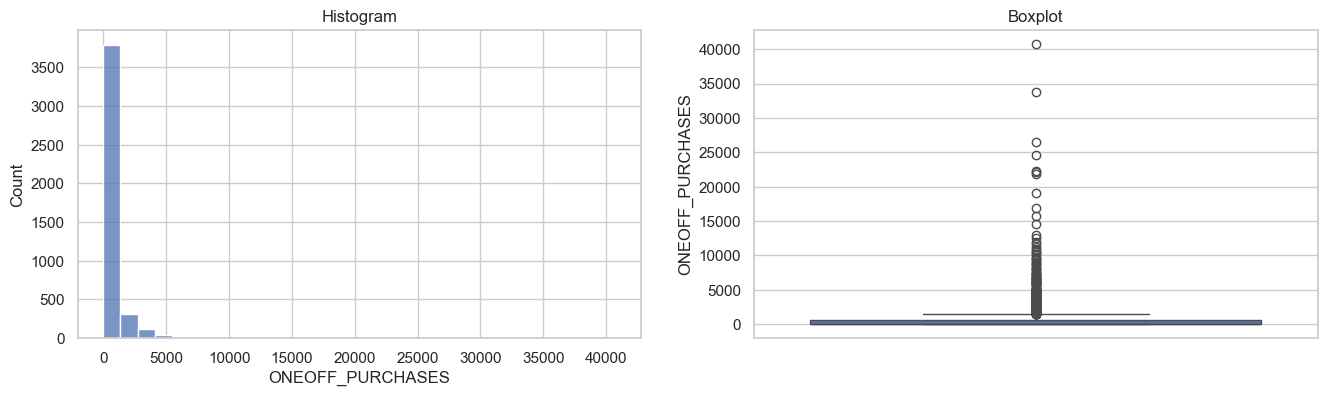


distance - Sesudah Capping


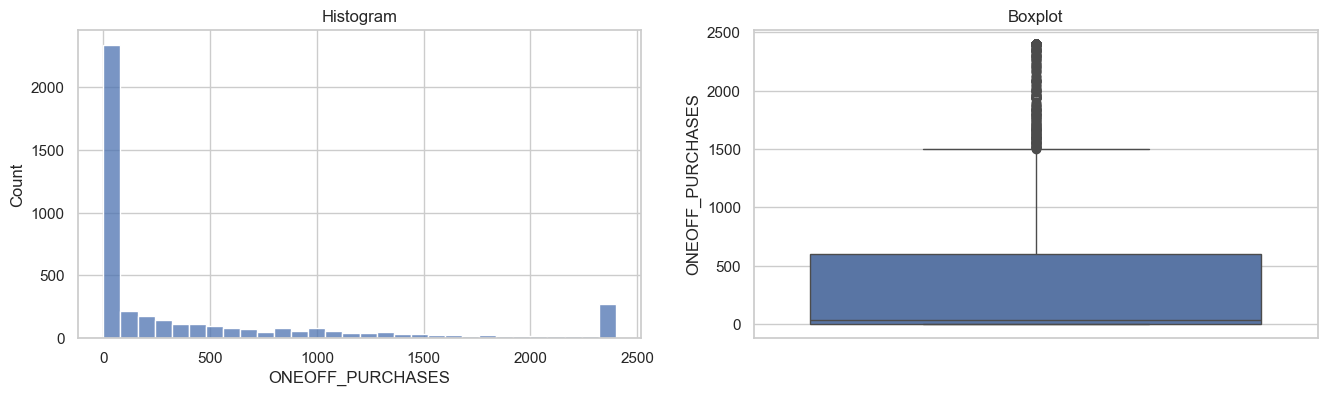

In [29]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'ONEOFF_PURCHASES')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'ONEOFF_PURCHASES')

distance - Sebelum Capping


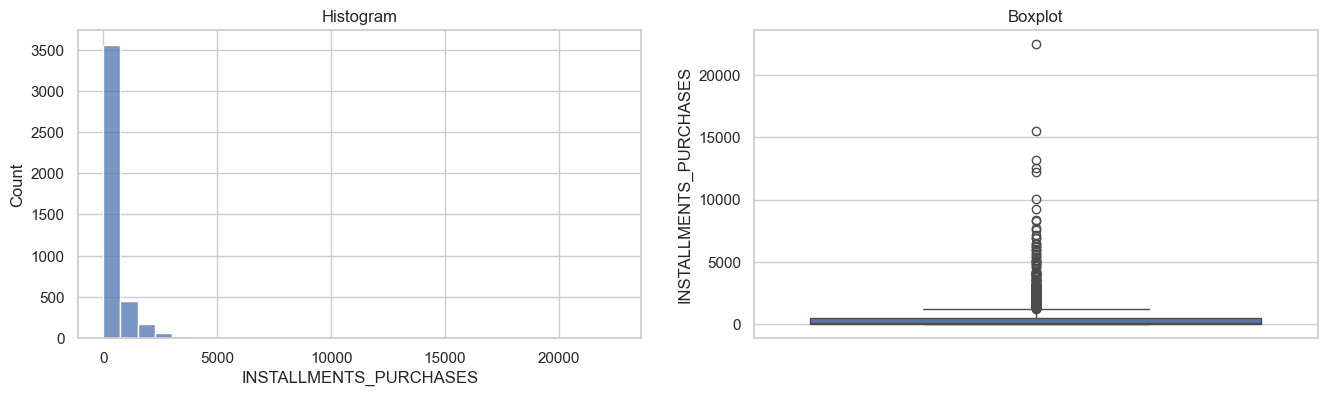


distance - Sesudah Capping


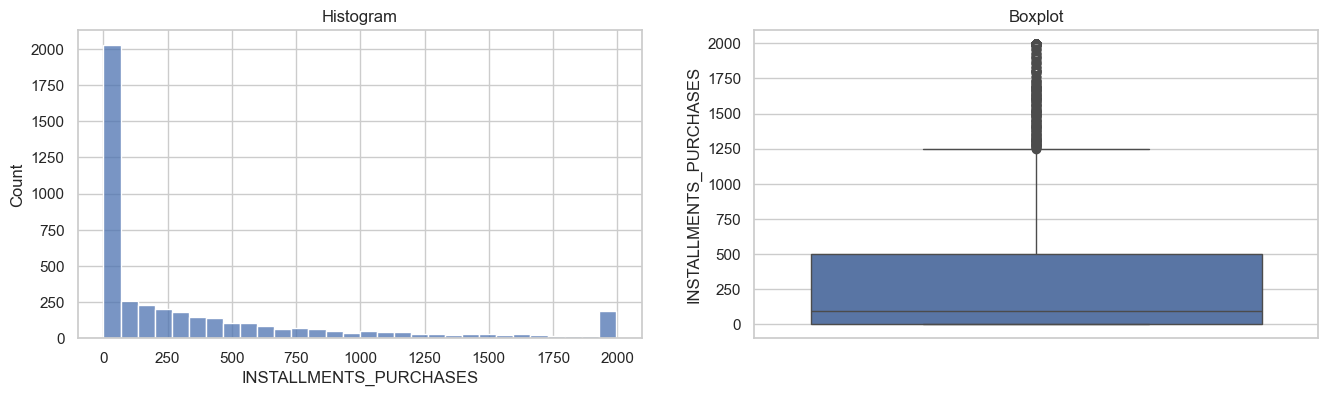

In [30]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'INSTALLMENTS_PURCHASES')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'INSTALLMENTS_PURCHASES')

distance - Sebelum Capping


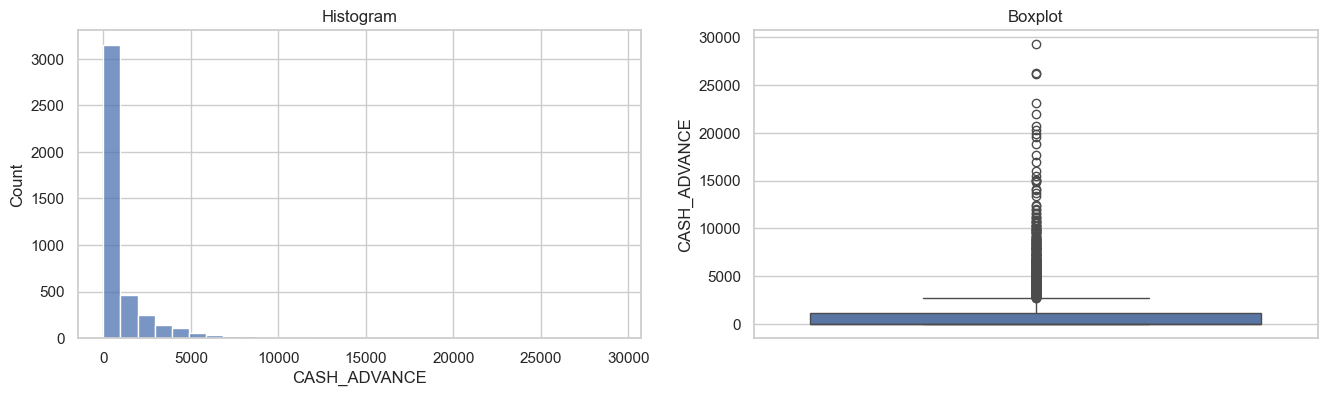


distance - Sesudah Capping


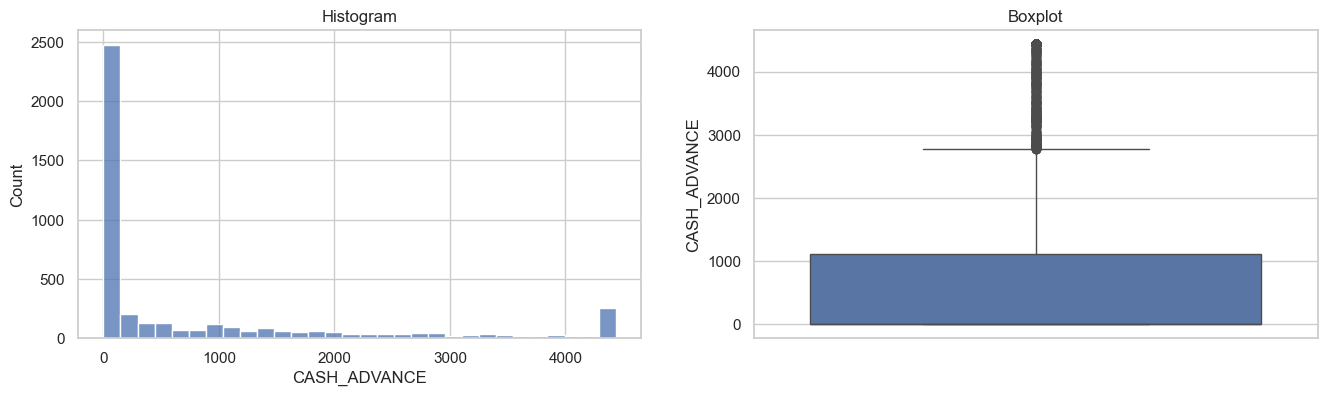

In [31]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'CASH_ADVANCE')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'CASH_ADVANCE')

distance - Sebelum Capping


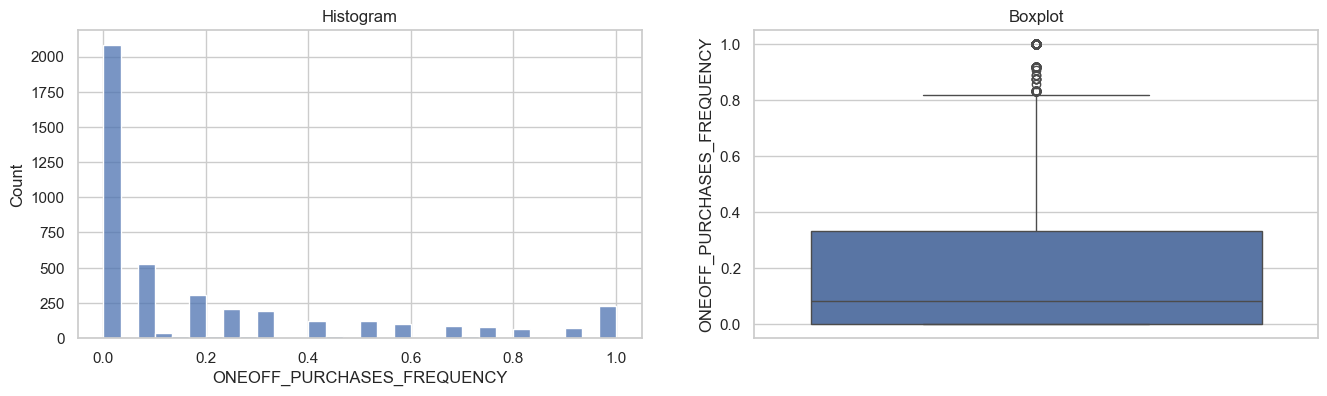


distance - Sesudah Capping


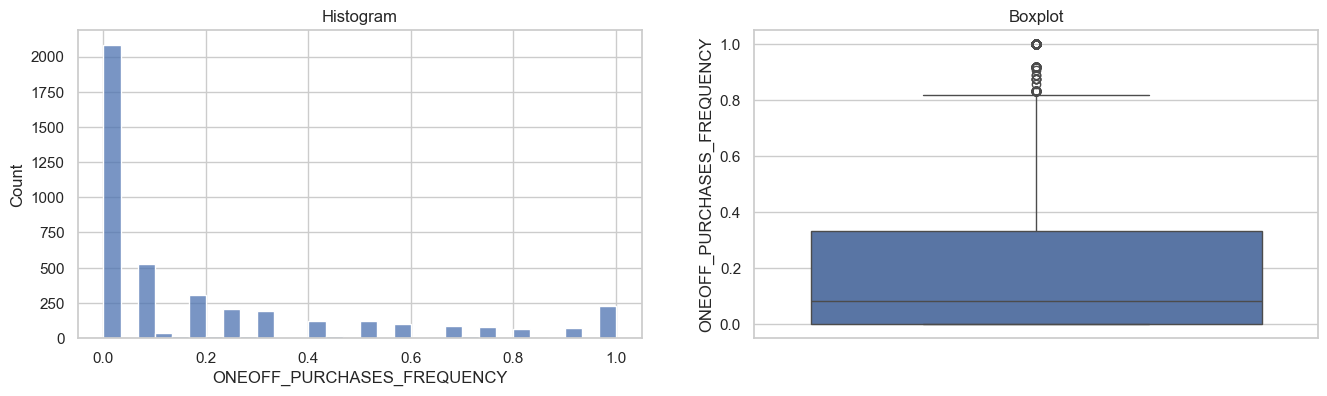

In [32]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'ONEOFF_PURCHASES_FREQUENCY')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'ONEOFF_PURCHASES_FREQUENCY')

distance - Sebelum Capping


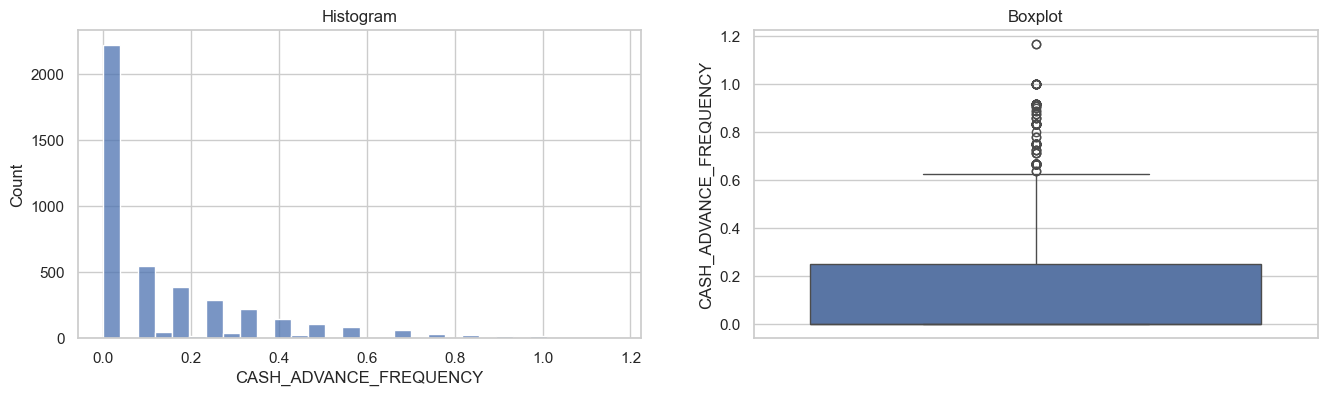


distance - Sesudah Capping


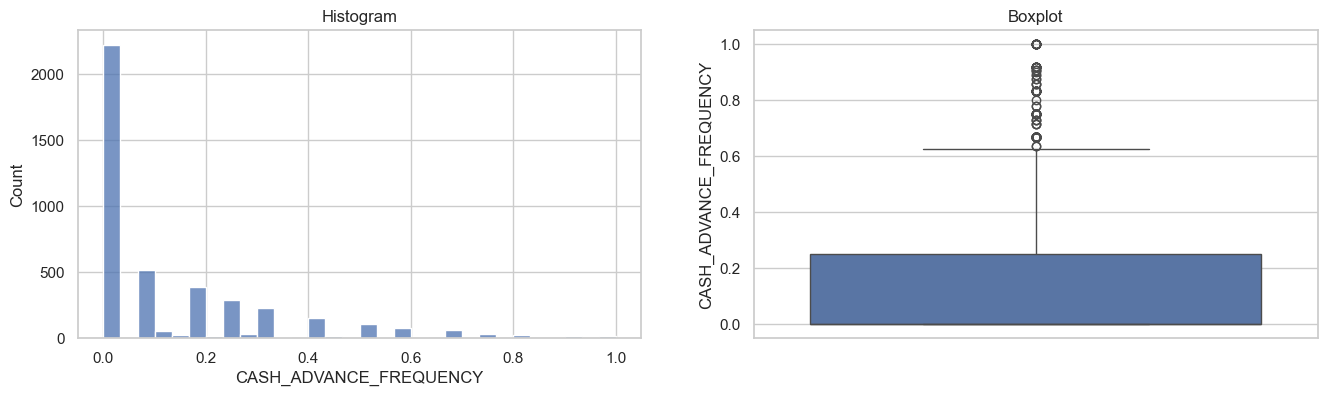

In [33]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'CASH_ADVANCE_FREQUENCY')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'CASH_ADVANCE_FREQUENCY')

distance - Sebelum Capping


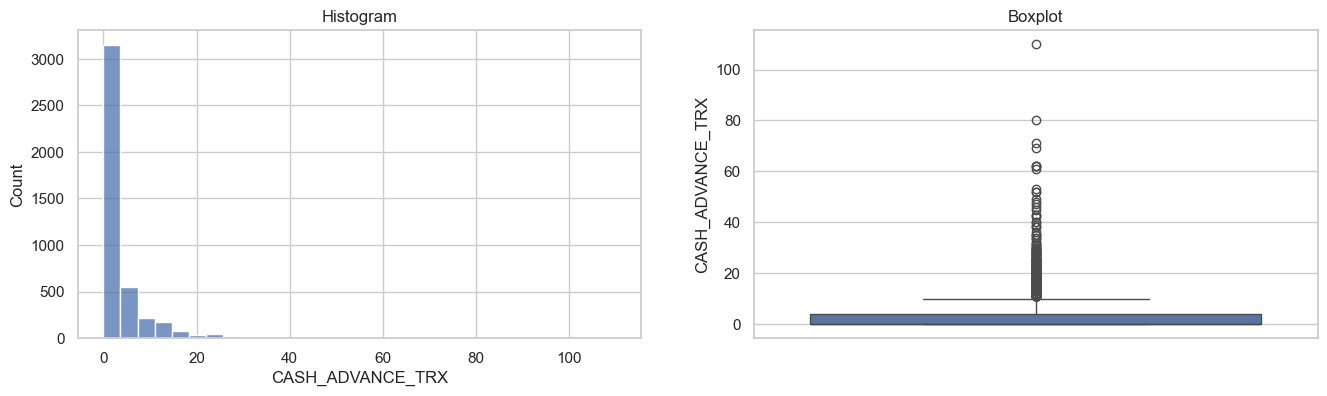


distance - Sesudah Capping


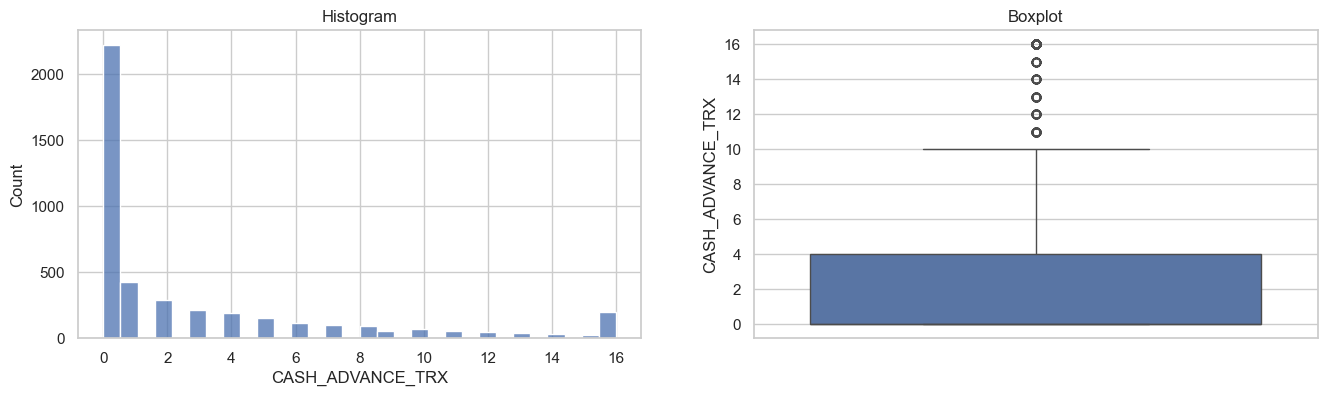

In [34]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'CASH_ADVANCE_TRX')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'CASH_ADVANCE_TRX')

distance - Sebelum Capping


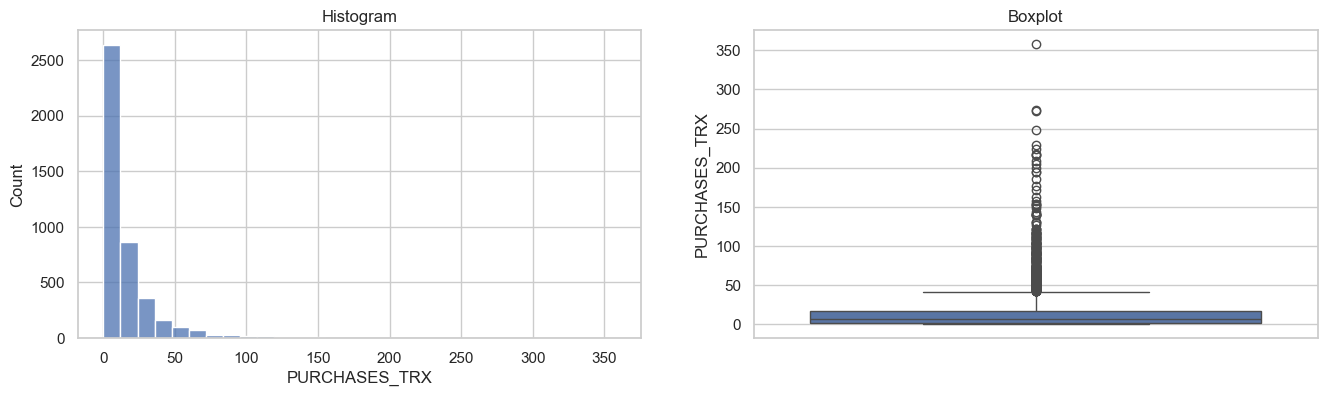


distance - Sesudah Capping


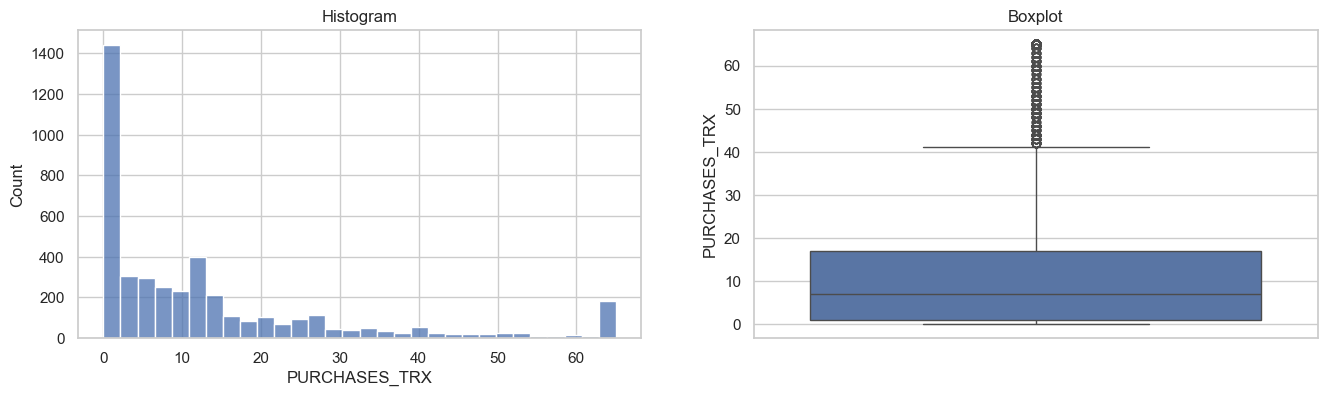

In [35]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'PURCHASES_TRX')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'PURCHASES_TRX')

distance - Sebelum Capping


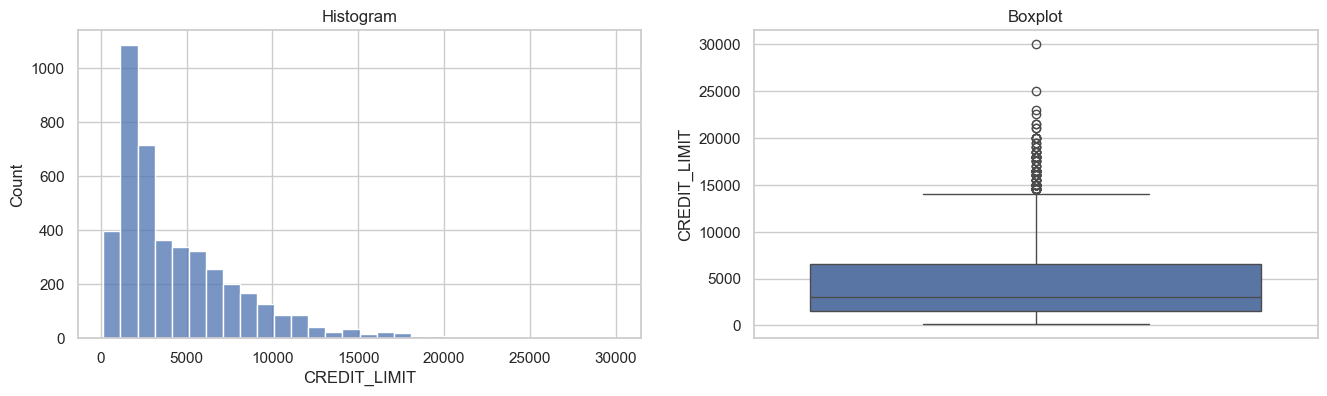


distance - Sesudah Capping


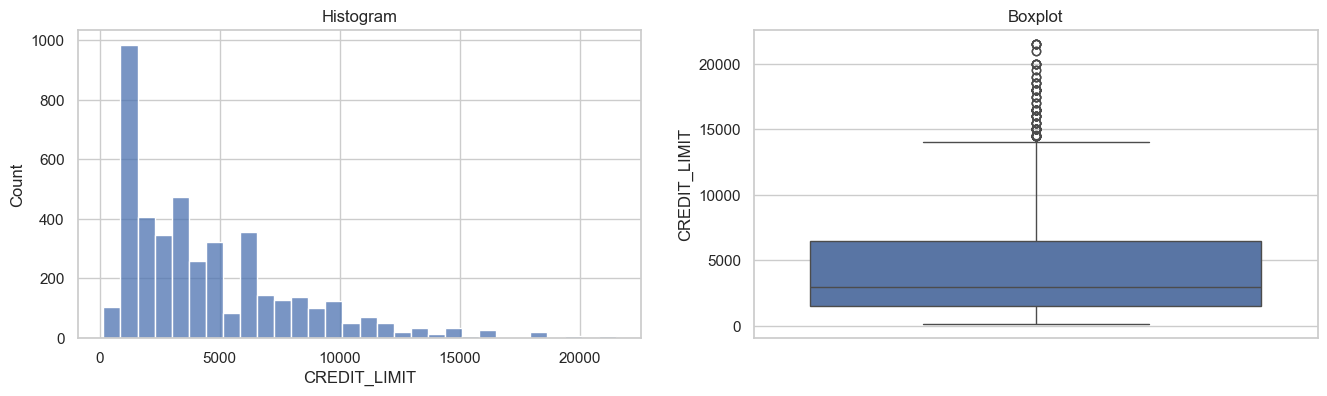

In [36]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'CREDIT_LIMIT')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'CREDIT_LIMIT')

distance - Sebelum Capping


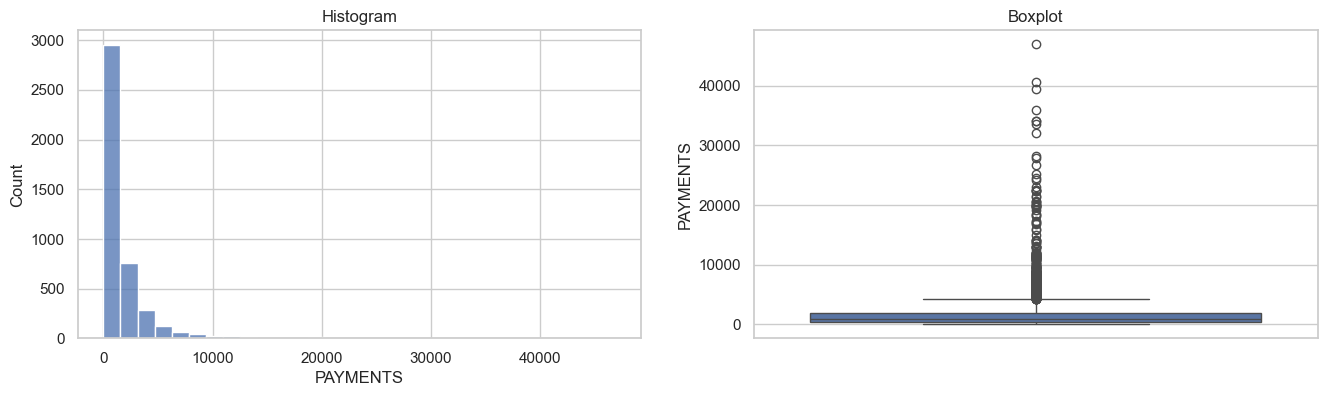


distance - Sesudah Capping


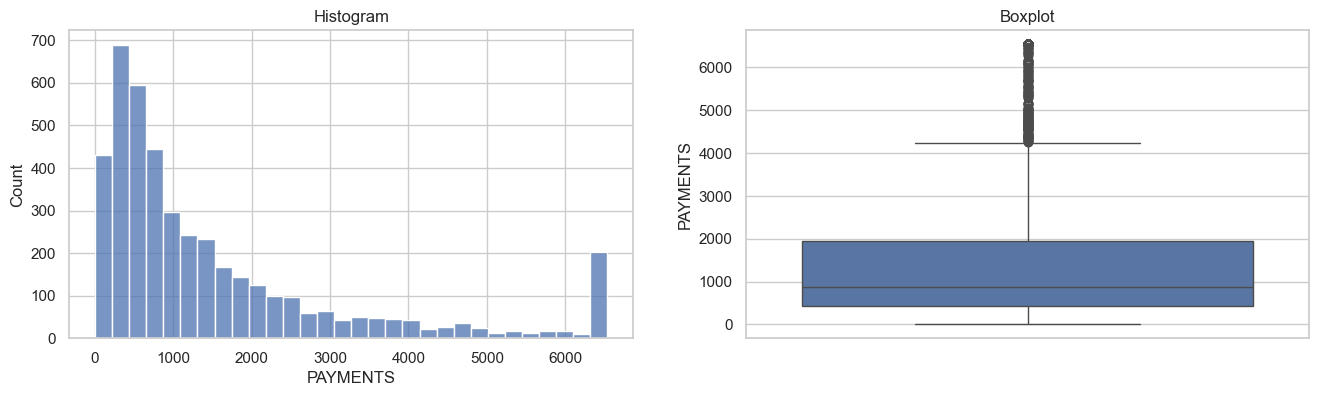

In [37]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'PAYMENTS')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'PAYMENTS')

distance - Sebelum Capping


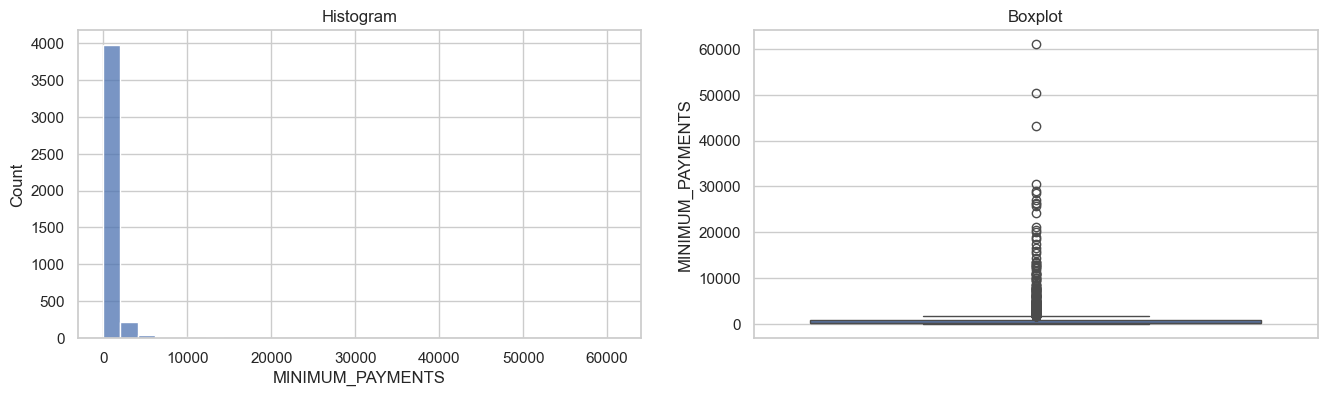


distance - Sesudah Capping


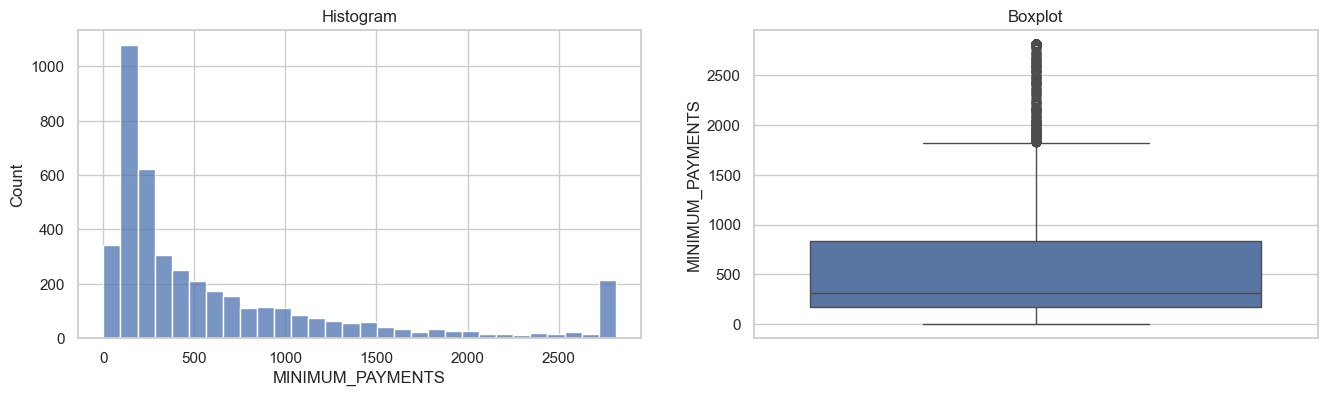

In [38]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'MINIMUM_PAYMENTS')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'MINIMUM_PAYMENTS')

distance - Sebelum Capping


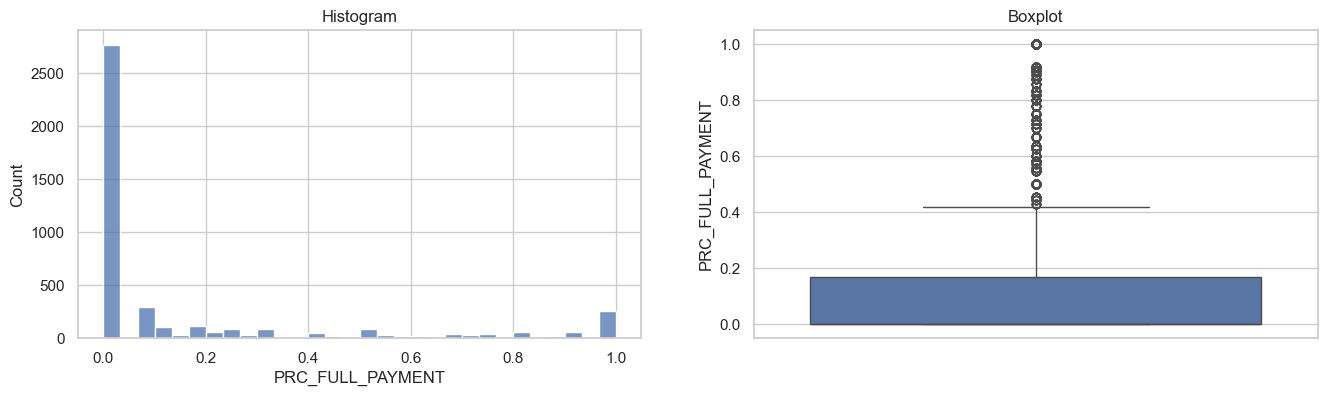


distance - Sesudah Capping


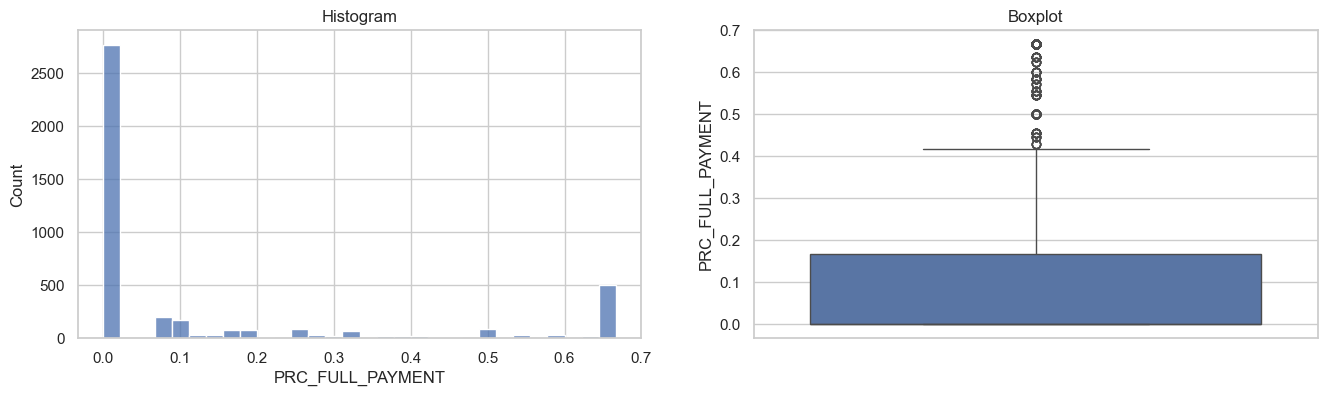

In [39]:
# menampilkan diagram sebelum di capping
print('distance - Sebelum Capping')
diagnostic_plots(df_1, 'PRC_FULL_PAYMENT')

# menampilkan diagram setelah di capping
print('\ndistance - Sesudah Capping')
diagnostic_plots(df_1_capped, 'PRC_FULL_PAYMENT')

### 5. Fiture Selection

Setelah kita melakukan capping,langkah selanjutnya yaitu memisahkan kolom mana saja yang tidak kita perlukan dengan menggunakan `.drop`.

In [40]:
# Gunakan .drop untuk menghapus kolom yang diinginkan
df_1_capped = df_1_capped.drop(['CUST_ID', 'TENURE'],axis=1)
df_1_capped.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0   943.584041           0.875000      103.0             103.0   
1   461.455720           1.000000      585.0             585.0   
2  1053.594730           1.000000     1450.0            1450.0   
3  2237.238086           1.000000      120.0             120.0   
4   424.994385           0.636364     1200.0            1200.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     0.0           0.0                0.125   
1                     0.0           0.0                0.125   
2                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125                               0.0   
1                       0.125                               0.0   
2                       0.125                               0.0   
3                       0.125                               0.0   
4                       0.125                               0.0   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              1        1000.0   
1                     0.0                 0              1        1000.0   
2                     0.0                 0              1        1500.0   
3                     0.0                 0              1        2500.0   
4                     0.0                 0              1        1200.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  
0  215.325023        410.484825               0.0  
1  258.032630        151.696433               0.0  
2  397.090516        227.143184               0.0  
3  343.102984        712.986387               0.0  
4   57.266292         56.720210               0.0

Karena kolom `CUST_ID` dan `TENURE` merupakan kolom categorical maka kita drop.

### 6. Feature Scaling

Pada bagian ini kita akan melakukan feature scalling menggunakan metode `MinMaxScaler` untuk membuat numerical data pada dataset memiliki rentang nilai(scale) yang sama. Tidak ada lagi satu variabel data yang mendominasi variabel data lainnya.

Setelah dilakukan analisis distribusi pada kolom numerik hasilnya adalah distribusi skew, maka kita akan menggunakan metode MinMaxScaler karena :

- MinMaxScaler menskalakan data ke rentang tetap, biasanya antara 0 dan 1.

- Meskipun (0, 1) adalah rentang default, kita juga dapat menentukan rentang nilai maks dan min.

- MinMaxScaler akan mempertahankan bentuk kumpulan data (tidak ada distorsi).

- Kapan menggunakan :

    ➔ Ketika kita mengetahui sebaran datanya bukan Gaussian.
    
    ➔ Berguna ketika algoritma tidak membuat asumsi tentang distribusi.

In [41]:
# scalling
scaler = ColumnTransformer([
    ('scaler', MinMaxScaler(), numeric_data)
], remainder='drop'
)

### 8. Pengurangan Dimensi

Sebelum melakukan clustering akan dilakukan reduksi dimensi menggunakan PCA dengan alasan sebagai berikut:

1. Terbukti bahwa data kita memiliki sejumlah fitur yang sangat banyak .

2. Banyak kasus yang menunjukkan bahwa ketika KMeans memanfaatkan hasil PCA, hasil clusteringnya lebih baik dibandingkan tanpa menggunakan PCA.

In [42]:
# Pengurangan Dimensi menggunakan PCA

pca = Pipeline([
    ('scaler', scaler),
    ('PCA', PCA())
])

pca.fit(df_1_capped)

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['BALANCE',
                                                   'BALANCE_FREQUENCY',
                                                   'PURCHASES',
                                                   'ONEOFF_PURCHASES',
                                                   'INSTALLMENTS_PURCHASES',
                                                   'CASH_ADVANCE',
                                                   'ONEOFF_PURCHASES_FREQUENCY',
                                                   'CASH_ADVANCE_FREQUENCY',
                                                   'CASH_ADVANCE_TRX',
                                                   'PURCHASES_TRX',
                                                   'CREDIT_LIMIT', 'PAYMENTS',
                                                   'MINIMUM_PAYMENTS',
                                                   'PRC_FULL_PAYMENT'])])),
                ('PCA', PCA())])

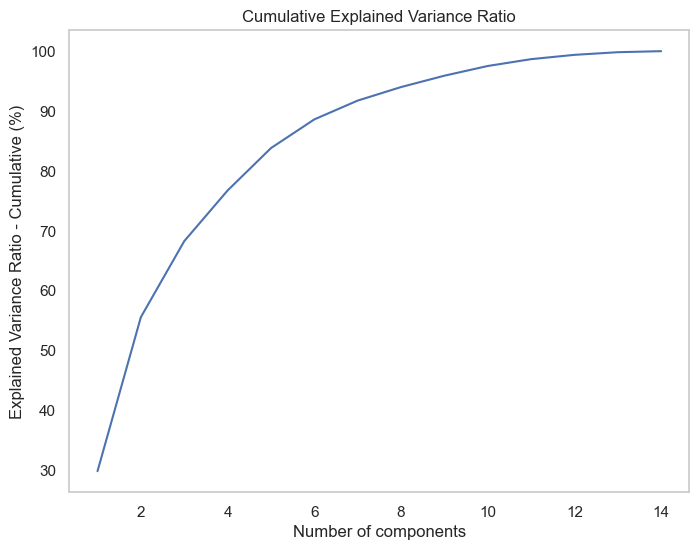

Number of features if we want to keep 95% information: 9 columns


In [43]:
# Hitung rasio varians yang dijelaskan secara kumulatif
cumulative_variance_ratio = np.cumsum(pca['PCA'].explained_variance_ratio_)

# Plot rasio varians yang dijelaskan secara kumulatif
plt.figure(figsize=[8, 6])
plt.grid()
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio * 100)
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cumulative (%)')
plt.title('Cumulative Explained Variance Ratio')
plt.show()

num_features = np.argmax(cumulative_variance_ratio >= 0.95) + 1 # tambahkan satu, karena indeks dimulai dengan 0
print(f'Number of features if we want to keep 95% information: {num_features} columns')

Langkah selanjutnya yaitu kita hitung varians kumulatifnya

In [44]:
# Hitung varians kumulatif yang dijelaskan
cumulative_variance = pca['PCA'].explained_variance_
cumulative_variance

array([0.31607826, 0.27230745, 0.13431792, 0.08959331, 0.07492247,
       0.0507699 , 0.03326923, 0.02391312, 0.02009138, 0.01715662,
       0.01211254, 0.0076092 , 0.00466973, 0.00182655])

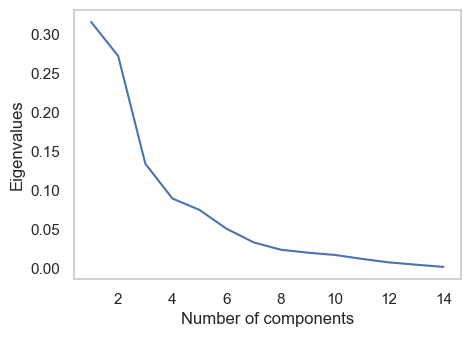

In [45]:
# Plot Nilai Eigen
plt.figure(figsize=[5, 3.5])
plt.grid()
plt.plot(range(1, 15), cumulative_variance )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.show()

Kami akan mengurangi fitur dari 16 fitur menjadi hanya 9 fitur yang mewakili dari keseluruhan data.

---

# Model Definition

### 1. Menemukan Jumlah Cluster yang Optimal

Langkah selanjutnya adalah menentukan berapa banyak cluster yang kita perlukan dengan mencoba mencari jumlah cluster yang optimal antara 2 cluster dan 15 cluster dengan metode Elbow membantu kita menentukan jumlah optimal kluster, Plot Silhouette membantu memvisualisasikan kualitas kluster, dan Skor Silhouette memberikan metrik numerik untuk mengukur kualitas clustering.

Pada bagian ini kita akan membuat cell untuk mendefinisikan model.

#### - *Menggunakan Metode Elbow*

In [46]:
# Mari kita latih model dengan 95% informasi kumpulan data asli
# buat pipeline yang berisi scaler dan PCA
pca = Pipeline(steps = [
    ('Scaler', StandardScaler()),  # Step 1: Scaler
    ('PCA', PCA(n_components=0.95))  # Step 2: PCA
])

df_num_final = pca.fit_transform(df_1_capped)

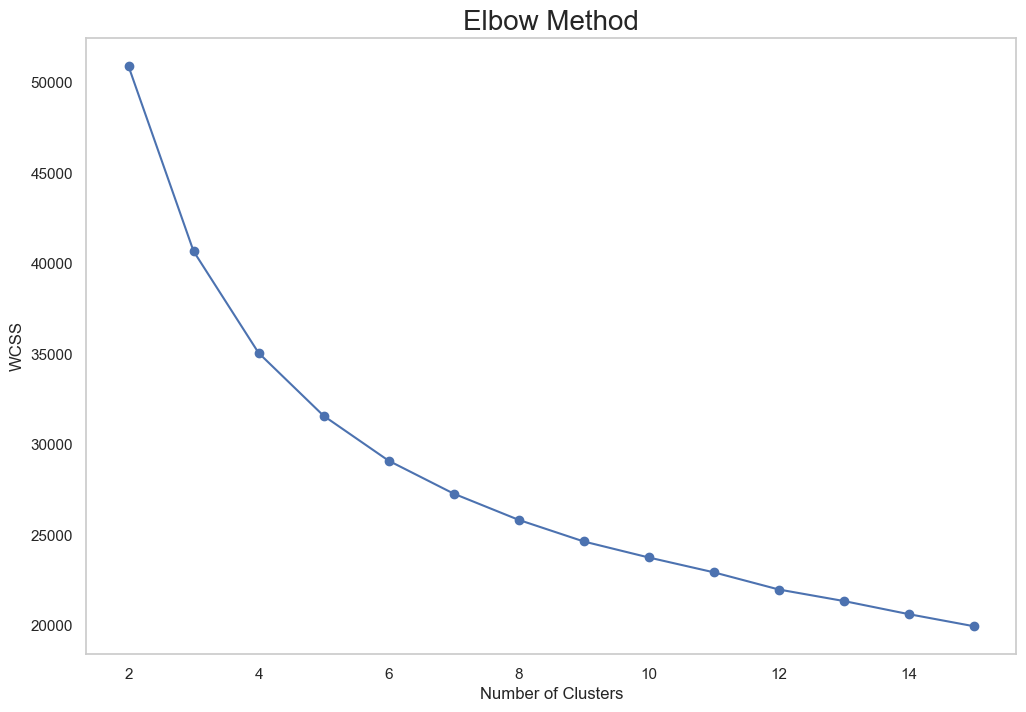

In [47]:
# Inisialisasi daftar kosong untuk menyimpan nilai Within-Cluster Sum of Squares (WCSS).
wcss = []

# Tetapkan keadaan acak tetap untuk reproduktifitas
random_state = 10

# Tentukan jumlah maksimum cluster yang akan dipertimbangkan
max_cluster = 15

# Ulangi rentang nomor cluster dari 2 hingga maksimum yang ditentukan
for i in range(2, max_cluster+1):
    # Buat model K-Means dengan cluster 'i', menggunakan inisialisasi cerdas (k-means++),
    # maksimal 300 iterasi, dan 10 inisialisasi
    km = KMeans(n_clusters=i,
                init='k-means++',
                max_iter=300,
                n_init=10,
                random_state=random_state)
    
    # Sesuaikan model K-Means dengan data yang telah diproses sebelumnya (df_num_capped)
    km.fit(df_num_final)
    
    # Hitung dan simpan Within-Cluster Sum of Squares (WCSS) untuk konfigurasi cluster ini
    wcss.append(km.inertia_)

# Plot nilai WCSS untuk jumlah cluster yang berbeda
plt.figure(figsize=(12,8))
plt.plot(range(2, max_cluster+1), wcss, marker="o")
plt.grid()
plt.title('Elbow Method', fontsize=20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

`*KESIMPULAN*`

Berdasarkan plot di atas, letak siku berada pada cluster 5.

#### - *Menggunakan Plot Silhoutte & Skor Silhoutte*

Selanjutnya kita akan menemukan skor siluet dan plot siluet.

In [48]:
# Berfungsi untuk membuat Plot Siluet
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Buat subplot dengan 1 baris dan 2 kolom
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # Subplot pertama adalah plot siluet
        # Koefisien siluet dapat berkisar dari -1, 1 tetapi dalam contoh ini semuanya berada dalam kisaran [-0,1, 1]
        ax1.set_xlim([-0.1, 1])
        # (n_clusters+1)*10 adalah untuk menyisipkan ruang kosong di antara plot siluet masing-masing cluster, untuk membatasinya dengan jelas.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Inisialisasi clusterer dengan nilai n_clusters dan seed generator acak 10 untuk reproduktifitas.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # Silhouette_score memberikan nilai rata-rata untuk semua sampel.
        # Hal ini memberikan perspektif mengenai kepadatan dan pemisahan cluster yang terbentuk
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Hitung skor siluet untuk setiap sampel
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Gabungkan skor siluet untuk sampel yang termasuk dalam cluster i, dan urutkan
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Beri label pada plot siluet dengan nomor clusternya di tengah
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Hitung y_lower baru untuk plot berikutnya
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # Garis vertikal untuk skor siluet rata-rata dari semua nilai
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # hapus yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot ke-2 menunjukkan cluster sebenarnya yang terbentuk
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Memberi label pada cluster
        centers = clusterer.cluster_centers_

        # Gambarlah lingkaran putih di pusat cluster
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.28755929211359155
For n_clusters = 3 The average silhouette_score is : 0.26544506646970195
For n_clusters = 4 The average silhouette_score is : 0.22154577867805242
For n_clusters = 5 The average silhouette_score is : 0.22683280403611583
For n_clusters = 6 The average silhouette_score is : 0.2327660722425884


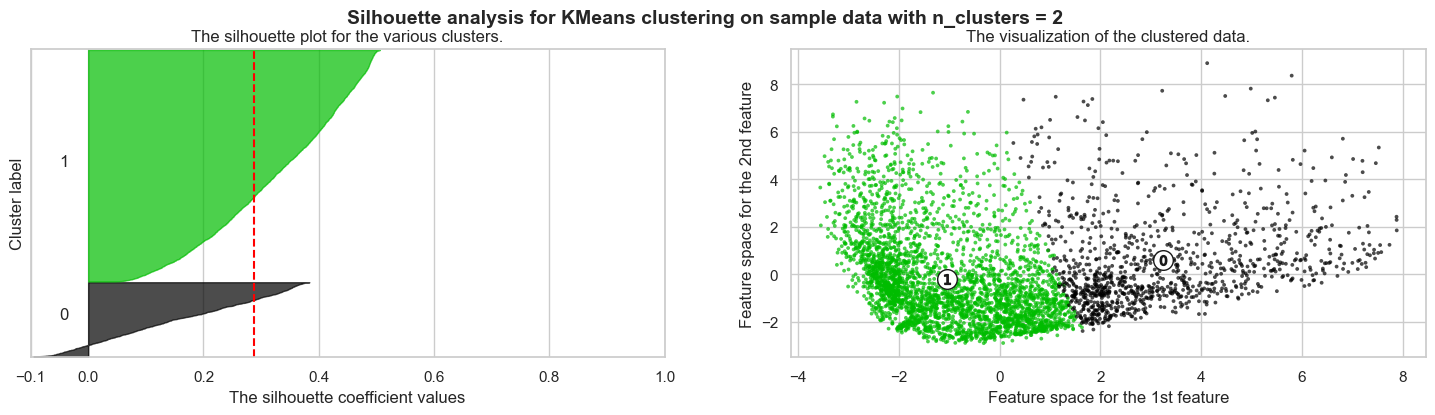

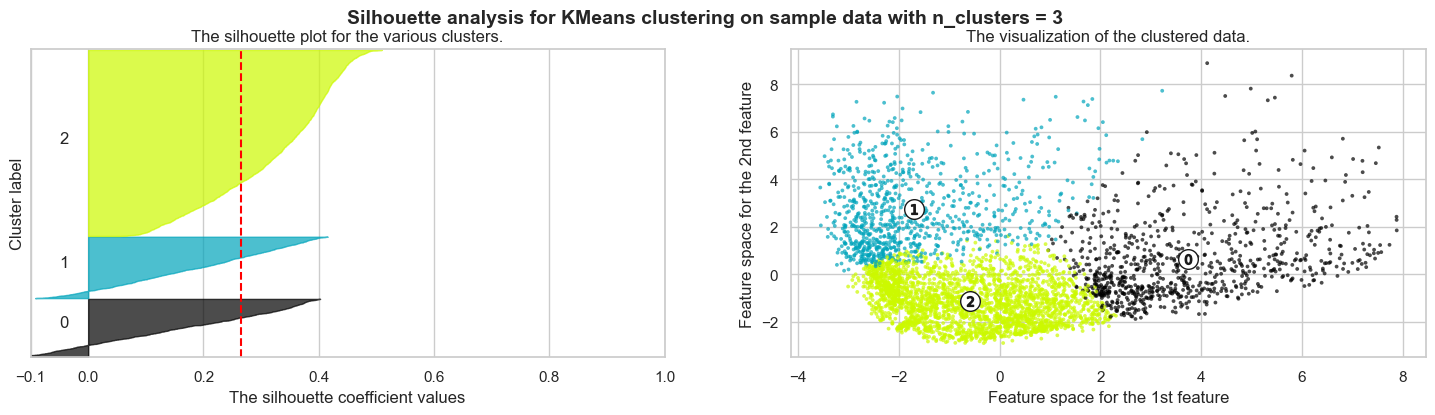

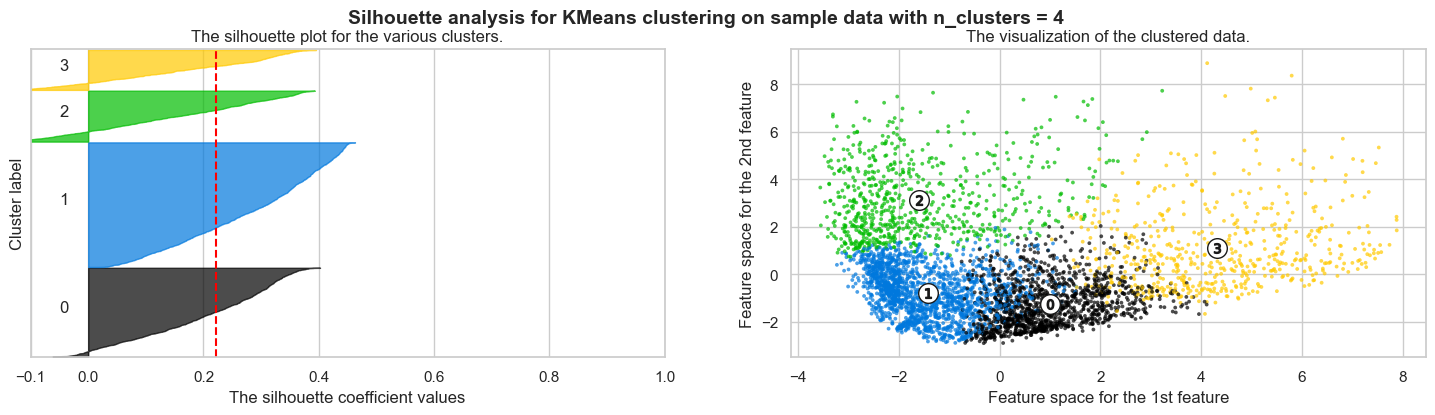

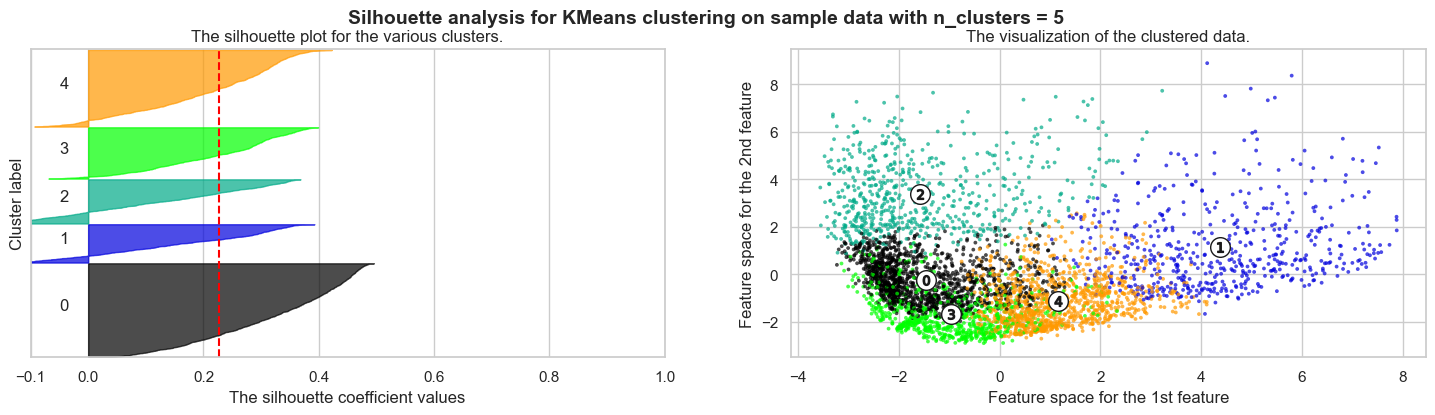

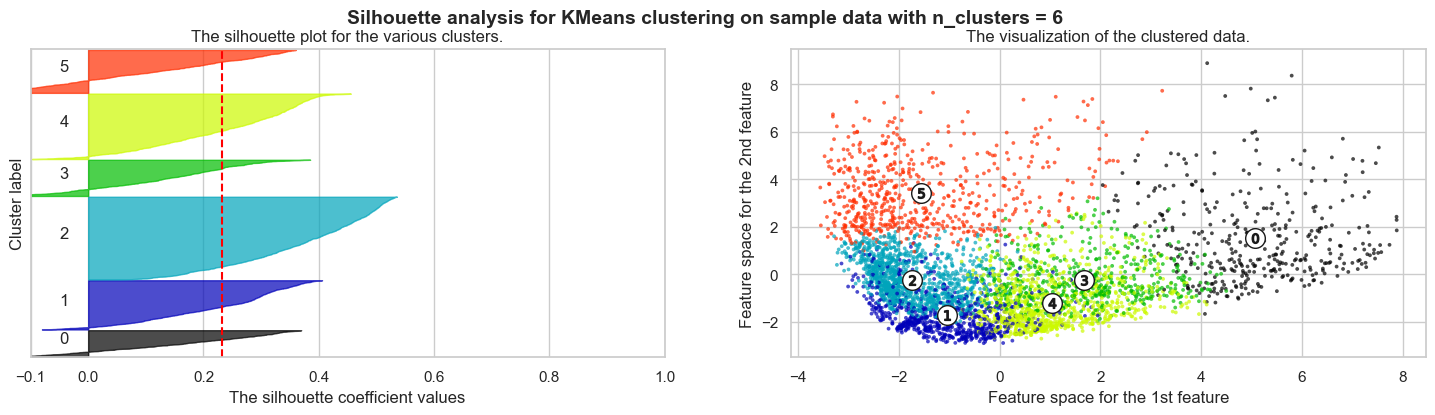

In [49]:
# Display the Silhouette Score and Plot Silhouette Plot
plot_silhouette(range(2, 7), df_num_final, 3002)

`*KESIMPULAN*`

- Jumlah cluster sebanyak 2 menghasilkan skor siluet rata-rata tertinggi (0.3213280231090381), yang menunjukkan cluster yang relatif terdefinisi dengan baik.

- Jumlah cluster 4, 5, dan 6 memiliki skor siluet yang sedikit lebih rendah namun masih masuk akal.
Skor yang turun untuk jumlah klaster di luar kisaran ini, menunjukkan pola pengelompokan yang kurang jelas atau bermakna.

- Singkatnya, jumlah cluster sebanyak 5 mungkin merupakan pilihan yang baik untuk data ini, karena memberikan skor siluet rata-rata tertinggi, yang menunjukkan cluster yang lebih terdefinisi.

#### - *Menentukan pipeline*

Membuat sebuah Pipeline dalam pengolahan data dan analisis komponen utama (PCA) yang diikuti oleh algoritma K-Means Clustering.

In [50]:
# Tentukan langkah-langkah dalam pipeline
steps = [
    ('scaler', scaler),  # Langkah 1: Data Scaling
    ('pca', PCA(n_components=0.95)),  # Langkah 2: Analisis Komponen Utama
    ('kmeans', KMeans(n_clusters=5, random_state=2022))  # Langkah 3: K-Means Clustering
]

# Buat pipeline
pipeline = Pipeline(steps)

In [51]:
# Sesuaikan pipeline dengan data
pipeline.fit(df_1)

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['BALANCE',
                                                   'BALANCE_FREQUENCY',
                                                   'PURCHASES',
                                                   'ONEOFF_PURCHASES',
                                                   'INSTALLMENTS_PURCHASES',
                                                   'CASH_ADVANCE',
                                                   'ONEOFF_PURCHASES_FREQUENCY',
                                                   'CASH_ADVANCE_FREQUENCY',
                                                   'CASH_ADVANCE_TRX',
                                                   'PURCHASES_TRX',
                                                   'CREDIT_LIMIT', 'PAYMENTS',
                                                   'MINIMUM_PAYMENTS',
                                                   'PRC_FULL_PAYMENT'])])),
                ('pca', PCA(n_components=0.95)),
                ('kmeans', KMeans(n_clusters=5, random_state=2022))])

Langkah ini digabungkan menjadi sebuah Pipeline, yang memungkinkan Anda menjalankannya secara berurutan dengan satu perintah. Ini berguna karena Anda dapat dengan mudah menerapkan algoritma preprocessing dan pemodelan secara bersamaan, dan Anda dapat memanfaatkan fitur-fitur dari scikit-learn, seperti cross-validation, untuk mengoptimalkan proses analisis data Anda.

#### - *Melatih dengan Jumlah Cluster yang Optimal*

In [52]:
# Membuat cluster prediction
cluster_pred = pipeline.fit_predict(df_1_capped)

Setelah membuat cluster prediction, langkah selanjutnya yaitu kita menambahkan kolom baru yang bernama `cluster` dari data awal kita. Fungsinya untuk melihat hasil identifikasi dari tiap baris pada data kita.

In [53]:
# Menambahkan kolom cluster dari data awal
df_1['cluster'] = cluster_pred
df_1.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     1902   943.584041              0.875      103.0             103.0   
1     3426   461.455720              1.000      585.0             585.0   
2     3976  1053.594730              1.000     1450.0            1450.0   
3     4266  2237.238086              1.000      120.0             120.0   
4     4680   424.994385              0.375     1200.0            1200.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     0.0           0.0                0.125   
1                     0.0           0.0                0.125   
2                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125                               0.0   
1                       0.125                               0.0   
2                       0.125                               0.0   
3                       0.125                               0.0   
4                       0.125                               0.0   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              1        1000.0   
1                     0.0                 0              1        1000.0   
2                     0.0                 0              1        1500.0   
3                     0.0                 0              1        2500.0   
4                     0.0                 0              1        1200.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
0  215.325023        410.484825               0.0       8        1  
1  258.032630        151.696433               0.0       8        1  
2  397.090516        227.143184               0.0       8        1  
3  343.102984        712.986387               0.0       8        1  
4   57.266292         56.720210               0.0       8        3

#### - *Distribusi cluster*

Kita tampilkan distribusi cluster menggunakan pie chart untuk melihat berapa banyak yang terdistribusi pada setiap cluster.

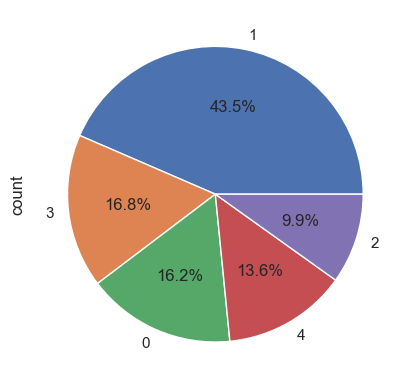

In [54]:
df_1['cluster'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

Dari hasil diatas kita mendapatkan cluster terbanyak yaitu ada pada cluster `1`, sedangkan yang paling sedikit yaitu ada pada cluster `2`.

#### 1. Cluster 0

In [55]:
# slice customer yang masuk ke cluster 0
cluster_0 = df_1[df_1['cluster']==0]
cluster_0

CUST_ID       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
1166     1742  12323.845360           1.000000     989.32            989.32   
2230     1816   5239.381493           0.625000       0.00              0.00   
2254      248   2936.600083           1.000000       0.00              0.00   
2258      424   3057.553683           1.000000       0.00              0.00   
2259      456    626.213492           1.000000       0.00              0.00   
...       ...           ...                ...        ...               ...   
4308     1226    706.327578           0.888889     169.54            169.54   
4311     8614    809.582978           0.909091       0.00              0.00   
4312     4296   3386.490883           1.000000     560.98            427.22   
4313     4476   4840.545574           1.000000    1595.93           1595.93   
4314     3564   1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
1166                    0.00      0.000000             0.090909   
2230                    0.00   9798.167329             0.000000   
2254                    0.00   3936.540697             0.000000   
2258                    0.00   2037.648071             0.000000   
2259                    0.00   3393.427055             0.000000   
...                      ...           ...                  ...   
4308                    0.00   1406.735573             0.333333   
4311                    0.00   3819.672466             0.000000   
4312                  133.76   2008.153534             1.000000   
4313                    0.00   4359.325750             0.454545   
4314                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
1166                    0.090909                          0.000000   
2230                    0.000000                          0.000000   
2254                    0.000000                          0.000000   
2258                    0.000000                          0.000000   
2259                    0.000000                          0.000000   
...                          ...                               ...   
4308                    0.333333                          0.000000   
4311                    0.000000                          0.000000   
4312                    0.727273                          0.363636   
4313                    0.454545                          0.000000   
4314                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
1166                0.000000                 0              2       18000.0   
2230                0.125000                 1              0       10000.0   
2254                0.250000                12              0        5000.0   
2258                0.250000                 3              0       12500.0   
2259                0.250000                11              0        1200.0   
...                      ...               ...            ...           ...   
4308                0.888889                14              3        2500.0   
4311                0.545455                 7              0        4150.0   
4312                0.545455                 9             20       10100.0   
4313                0.545455                17             25        6000.0   
4314                0.545455                21             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
1166  9542.247486       2540.084696          0.000000      11        0  
2230  1345.580941       2011.806301          0.000000       8        0  
2254  1861.424668        669.400628          0.000000      12        0  
2258  7265.976143        847.170642          0.000000      12        0  
2259  3566.140224        473.448279          0.250000      12        0  
...           ...       

<Axes: ylabel='Frequency'>

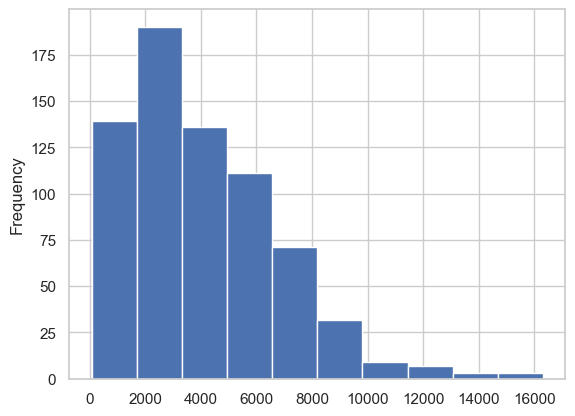

In [56]:
cluster_0['BALANCE'].plot(kind='hist')

#### 2. Cluster 1

In [57]:
# slice customer yang masuk ke cluster 0
cluster_1 = df_1[df_1['cluster']==1]
cluster_1

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0        1902   943.584041           0.875000     103.00            103.00   
1        3426   461.455720           1.000000     585.00            585.00   
2        3976  1053.594730           1.000000    1450.00           1450.00   
3        4266  2237.238086           1.000000     120.00            120.00   
6         172   867.728471           1.000000      41.07              0.00   
...       ...          ...                ...        ...               ...   
4302     6094   851.880648           0.909091    1476.70            934.59   
4303      980   392.896462           0.909091     450.00            450.00   
4305     1588   538.768762           0.909091     226.95            129.58   
4309     2152  1420.727073           1.000000       0.00              0.00   
4310     4630  1079.008102           1.000000       0.00              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                       0.00      0.000000             0.125000   
1                       0.00      0.000000             0.125000   
2                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
6                      41.07      0.000000             0.250000   
...                      ...           ...                  ...   
4302                  542.11    903.935644             0.636364   
4303                    0.00    517.197717             0.818182   
4305                   97.37    452.009130             0.545455   
4309                    0.00    311.804499             0.000000   
4310                    0.00   1259.571764             0.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125000                          0.000000   
1                       0.125000                          0.000000   
2                       0.125000                          0.000000   
3                       0.125000                          0.000000   
6                       0.000000                          0.250000   
...                          ...                               ...   
4302                    0.454545                          0.363636   
4303                    0.818182                          0.000000   
4305                    0.090909                          0.454545   
4309                    0.000000                          0.000000   
4310                    0.000000                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              1        1000.0   
1                   0.000000                 0              1        1000.0   
2                   0.000000                 0              1        1500.0   
3                   0.000000                 0              1        2500.0   
6                   0.000000                 0              3        3000.0   
...                      ...               ...            ...           ...   
4302                0.272727                 3             18        1200.0   
4303                0.272727                 5              9         500.0   
4305                0.272727                 8              9        1200.0   
4309                0.900000                 9              0        1500.0   
4310                0.545455                 9              0        1200.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
0      215.325023        410.484825          0.000000       8        1  
1      258.032630        151.696433          0.000000       8        1  
2      397.090516        227.143184          0.000000       8        1  
3      343.102984        712.986387          0.000000       8        1  
6     1409.282903        233.788637          0.000000      12        1  
...           ...               ... 

<Axes: ylabel='Frequency'>

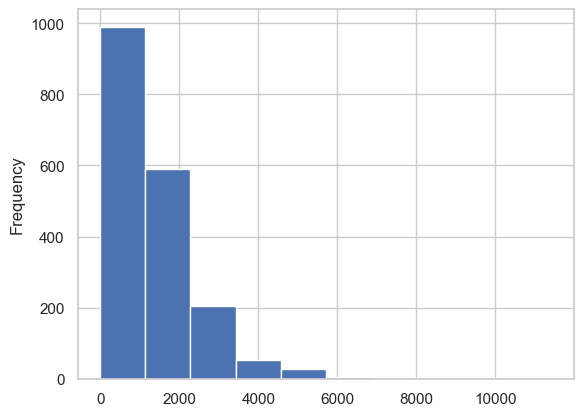

In [58]:
cluster_1['BALANCE'].plot(kind='hist')

#### 3. Cluster 2

In [59]:
# slice customer yang masuk ke cluster 0
cluster_2 = df_1[df_1['cluster']==2]
cluster_2

CUST_ID     BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
23       1882  154.641707           0.363636    1897.92             97.92   
137      1468  169.343874           0.818182    1553.80           1553.80   
140      1762  588.795215           0.636364    4116.00              0.00   
153      2664  170.907823           0.909091    1366.30           1366.30   
156      3020   47.587585           0.727273     414.80             53.00   
...       ...         ...                ...        ...               ...   
3446     6706  282.070933           1.000000    1926.19            569.80   
3485     5482  368.367166           1.000000    1121.86            169.20   
3837     4022  162.267397           1.000000     907.99            907.99   
3913     4632  189.499535           1.000000    1802.93            813.55   
4264     7766   30.863497           0.818182     143.36              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
23                   1800.00      0.000000             0.250000   
137                     0.00      0.000000             0.500000   
140                  4116.00      0.000000             0.500000   
153                     0.00      0.000000             0.500000   
156                   361.80      0.000000             0.500000   
...                      ...           ...                  ...   
3446                 1356.39    500.865079             1.000000   
3485                  952.66   1172.195497             0.666667   
3837                    0.00    339.493008             1.000000   
3913                  989.38    258.954597             0.916667   
4264                  143.36    736.547491             0.666667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
23                      0.166667                          0.166667   
137                     0.500000                          0.000000   
140                     0.000000                          0.500000   
153                     0.500000                          0.000000   
156                     0.083333                          0.416667   
...                          ...                               ...   
3446                    0.333333                          0.916667   
3485                    0.083333                          0.583333   
3837                    1.000000                          0.000000   
3913                    0.416667                          0.833333   
4264                    0.000000                          0.666667   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
23                  0.000000                 0              5       13500.0   
137                 0.000000                 0              8       16500.0   
140                 0.000000                 0             12       21500.0   
153                 0.000000                 0             11        2000.0   
156                 0.000000                 0              8        4500.0   
...                      ...               ...            ...           ...   
3446                0.333333                 6             43        7000.0   
3485                0.333333                 5             11        3500.0   
3837                0.166667                 2              8        1120.0   
3913                0.166667                 5             35        1000.0   
4264                0.416667                 5              8        1500.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
23    5563.437084        248.700571          1.000000      12        2  
137   1921.042991        125.895667          0.800000      12        2  
140   8130.112361        224.763498          1.000000      12        2  
153   3453.112338        139.388035          0.400000      12        2  
156    545.768039        135.094235          1.000000      12        2  
...           ...               ...             

<Axes: ylabel='Frequency'>

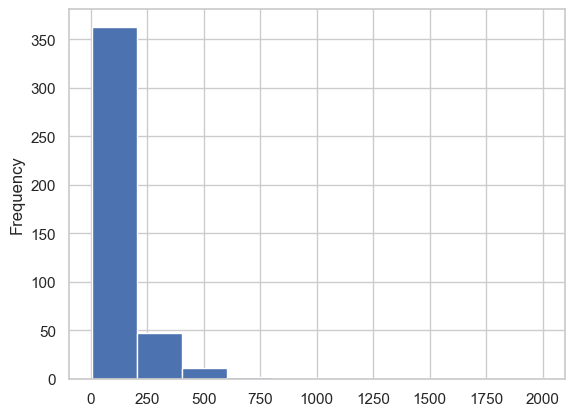

In [60]:
cluster_2['BALANCE'].plot(kind='hist')

#### 4. Cluster 3

In [61]:
# slice customer yang masuk ke cluster 0
cluster_3 = df_1[df_1['cluster']==3]
cluster_3

CUST_ID     BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
4        4680  424.994385           0.375000     1200.0            1200.0   
5          24    0.004816           0.545455       51.7               0.0   
7         190   41.255670           0.454545      297.4             297.4   
11        422   64.080909           0.454545      927.0             600.0   
12        540   10.286805           0.363636       60.0               0.0   
...       ...         ...                ...        ...               ...   
4153     5988   98.418953           0.555556        0.0               0.0   
4156      742  783.550476           0.777778      175.8             175.8   
4199     6186  567.055953           0.727273        0.0               0.0   
4207     7252   15.523256           0.454545        0.0               0.0   
4292     2630  458.403218           0.727273        0.0               0.0   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
4                        0.0      0.000000             0.125000   
5                       51.7      0.000000             0.250000   
7                        0.0      0.000000             0.250000   
11                     327.0      0.000000             0.250000   
12                      60.0      0.000000             0.250000   
...                      ...           ...                  ...   
4153                     0.0   2327.566908             0.000000   
4156                     0.0   2052.878473             0.444444   
4199                     0.0   3254.666530             0.000000   
4207                     0.0    357.184643             0.000000   
4292                     0.0   2249.627477             0.000000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
4                       0.125000                          0.000000   
5                       0.000000                          0.250000   
7                       0.250000                          0.000000   
11                      0.083333                          0.166667   
12                      0.000000                          0.250000   
...                          ...                               ...   
4153                    0.000000                          0.000000   
4156                    0.444444                          0.000000   
4199                    0.000000                          0.000000   
4207                    0.000000                          0.000000   
4292                    0.000000                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
4                   0.000000                 0              1        1200.0   
5                   0.000000                 0              3        3000.0   
7                   0.000000                 0              5        6000.0   
11                  0.000000                 0              4        5000.0   
12                  0.000000                 0              3        1000.0   
...                      ...               ...            ...           ...   
4153                0.444444                15              0        1500.0   
4156                0.444444                 6              5        2500.0   
4199                0.416667                11              0        6000.0   
4207                0.416667                12              0         500.0   
4292                0.272727                 6              0        1200.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
4       57.266292         56.720210          0.000000       8        3  
5       33.249088          0.059481          0.000000      12        3  
7      595.460601        173.255085          0.333333      12        3  
11    1260.163840         59.044390          0.222222      12        3  
12     194.460801        141.594889          0.250000      12        3  
...           ...               ...             

<Axes: ylabel='Frequency'>

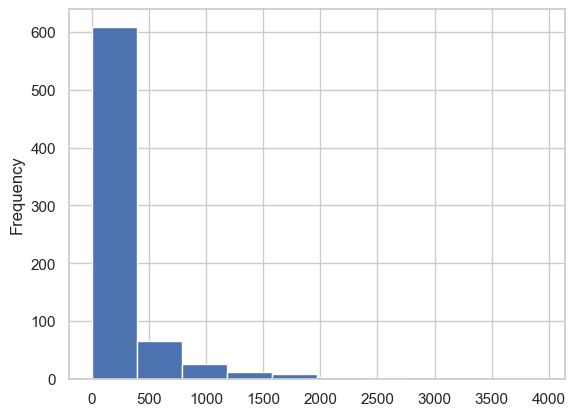

In [62]:
cluster_3['BALANCE'].plot(kind='hist')

#### 5. Cluster 4

In [63]:
# slice customer yang masuk ke cluster 0
cluster_4 = df_1[df_1['cluster']==4]
cluster_4

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
49       3814   939.152528           1.000000    3393.25           3364.59   
124       812   311.341555           0.909091    3721.39           3721.39   
179      4664  4060.710208           0.727273   22500.00              0.00   
182      4734   336.749543           0.818182    3081.69           3081.69   
198      5768   616.570241           0.818182    5788.81           5788.81   
...       ...          ...                ...        ...               ...   
4231     3186  1663.492233           1.000000    3415.39           2355.11   
4238     6470   844.837833           1.000000    2196.38           1868.83   
4240     7368  4755.943819           1.000000    3785.85           3583.95   
4243     7812   177.602057           1.000000    2863.31           2407.53   
4300     4842  1735.137321           1.000000    1879.92           1879.92   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
49                     77.66      0.000000             0.250000   
124                     0.00      0.000000             0.500000   
179                 22500.00      0.000000             0.500000   
182                     0.00      0.000000             0.500000   
198                     0.00      0.000000             0.500000   
...                      ...           ...                  ...   
4231                 1060.28   4152.202096             1.000000   
4238                  327.55   2716.839070             1.000000   
4240                  201.90    529.171674             1.000000   
4243                  455.78    832.203874             1.000000   
4300                    0.00    934.051432             0.454545   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
49                      0.250000                          0.083333   
124                     0.500000                          0.000000   
179                     0.000000                          0.416667   
182                     0.500000                          0.000000   
198                     0.500000                          0.000000   
...                          ...                               ...   
4231                    0.666667                          1.000000   
4238                    1.000000                          0.166667   
4240                    1.000000                          0.166667   
4243                    0.583333                          0.750000   
4300                    0.454545                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
49                  0.000000                 0              5        9000.0   
124                 0.000000                 0             26        4000.0   
179                 0.000000                 0             12       23000.0   
182                 0.000000                 0             22        2000.0   
198                 0.000000                 0             13        7000.0   
...                      ...               ...            ...           ...   
4231                0.416667                 7             44        8500.0   
4238                0.416667                 7             23        5000.0   
4240                0.416667                12             46       10500.0   
4243                0.416667                10             27        1500.0   
4300                0.272727                 3              8        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
49    2768.821579        267.093439          0.000000      12        4  
124   4004.905569        156.580586          0.714286      12        4  
179   8760.860264       1645.535202          0.000000      12        4  
182   3631.007239        133.854497          0.000000      12        4  
198   5891.252034        285.762299          0.200000      12        4  
...           ...               ... 

<Axes: ylabel='Frequency'>

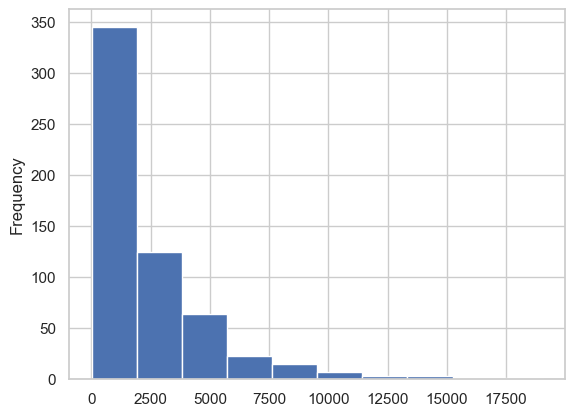

In [64]:
cluster_4['BALANCE'].plot(kind='hist')

#### - *Kesimpulan Cluster*

In [65]:
df_1.groupby(by = 'cluster').mean()

CUST_ID      BALANCE  BALANCE_FREQUENCY    PURCHASES  \
cluster                                                             
0        4372.970043  4129.251963           0.969827   468.489800   
1        4500.669153  1314.018778           0.986789   442.090298   
2        4694.239437   118.203936           0.941588  1013.014131   
3        4477.870523   200.886275           0.490708   371.986791   
4        4343.777778  2301.082529           0.980197  4384.806085   

         ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
cluster                                                           
0              275.479073              193.106234   4175.456653   
1              221.054353              221.451758    385.340279   
2              228.018779              785.204225     22.472985   
3              211.738292              161.181694    441.409987   
4             2963.910017             1420.979829    475.093298   

         PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
cluster                                                    
0                   0.286542                    0.111282   
1                   0.427331                    0.137071   
2                   0.884906                    0.175803   
3                   0.308263                    0.083800   
4                   0.915411                    0.710439   

         PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
cluster                                                             
0                                0.195619                0.448787   
1                                0.313441                0.104960   
2                                0.749396                0.009296   
3                                0.218202                0.047822   
4                                0.671733                0.063740   

         CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT     PAYMENTS  \
cluster                                                               
0               12.928673       6.553495   6793.009986  3333.656400   
1                1.765583       8.614811   3152.344166   827.567358   
2                0.136150      17.955399   4052.394366  1113.953329   
3                0.929752       5.064738   3599.028160  1305.174017   
4                1.570940      54.348718   7702.362082  4093.263588   

         MINIMUM_PAYMENTS  PRC_FULL_PAYMENT     TENURE  
cluster                                                 
0             1763.196540          0.041314  11.353780  
1              875.266367          0.021027  11.593500  
2              202.728204          0.711591  11.464789  
3              200.123226          0.260968  11.331956  
4              987.085396          0.243531  11.841026

Dari hasil diatas dapat kita simpulkan bahwa :

1. Cluster 0

    - Rata-rata saldo (BALANCE) di cluster ini sekitar 4,372.97.
    - Pelanggan dalam cluster ini memiliki nilai BALANCE_FREQUENCY yang tinggi.
    - Pembelian rata-rata (PURCHASES) adalah sekitar 468.49, dengan komponen ONEOFF_PURCHASES dan INSTALLMENTS_PURCHASES yang cukup seimbang.
    - Pelanggan dalam cluster ini memiliki Cash Advance (CASH_ADVANCE) yang tinggi, rata-rata sekitar 4,175.46.
    - Pembelian seringkali terjadi di cluster ini, dengan PURCHASES_FREQUENCY tinggi.
    - Pelanggan dalam cluster ini sering melakukan pembelian secara satu kali (ONEOFF_PURCHASES) dan pembelian dengan angsuran (INSTALLMENTS_PURCHASES).
    - Mereka memiliki CREDIT_LIMIT yang cukup tinggi, rata-rata sekitar 6,793.01.
    - Tingkat pembayaran (PAYMENTS) juga tinggi, dengan rata-rata sekitar 3,333.66.
    - Pelanggan dalam cluster ini cenderung melakukan pembayaran penuh (PRC_FULL_PAYMENT rendah) dan memiliki TENURE (masa tenor) yang tinggi.

2.  Cluster 1

    - Rata-rata saldo (BALANCE) di cluster ini sekitar 4,500.67.
    - Pelanggan dalam cluster ini memiliki nilai BALANCE_FREQUENCY yang tinggi.
    - Pembelian rata-rata (PURCHASES) adalah sekitar 442.09, dengan komponen ONEOFF_PURCHASES dan INSTALLMENTS_PURCHASES yang seimbang.
    - Pelanggan dalam cluster ini memiliki Cash Advance (CASH_ADVANCE) yang lebih rendah daripada Cluster 0.
    - Mereka juga sering berbelanja (PURCHASES_FREQUENCY tinggi).
    - Pembelian satu kali (ONEOFF_PURCHASES) dan pembelian dengan angsuran (INSTALLMENTS_PURCHASES) terjadi dengan frekuensi yang cukup tinggi.
    - CREDIT_LIMIT mereka lebih rendah dibandingkan dengan Cluster 0.
    - Tingkat pembayaran (PAYMENTS) juga lebih rendah.
    - Pelanggan dalam cluster ini cenderung melakukan pembayaran penuh (PRC_FULL_PAYMENT rendah) dan memiliki TENURE yang tinggi.

3. Cluster 2

    - Rata-rata saldo (BALANCE) di cluster ini sekitar 4,694.24.
    - Pelanggan dalam cluster ini memiliki nilai BALANCE_FREQUENCY yang rendah.
    - Pembelian rata-rata (PURCHASES) adalah sekitar 1,013.01, dengan komponen ONEOFF_PURCHASES yang tinggi.
    - Cluster ini memiliki Cash Advance (CASH_ADVANCE) yang sangat rendah.
    - Mereka sering melakukan pembelian (PURCHASES_FREQUENCY tinggi) dan pembelian satu kali (ONEOFF_PURCHASES) terjadi secara teratur.
    - CREDIT_LIMIT mereka lebih rendah dibandingkan dengan Cluster 0 dan Cluster 1.
    - Tingkat pembayaran (PAYMENTS) lebih rendah.
    - Pelanggan dalam cluster ini cenderung melakukan pembayaran penuh (PRC_FULL_PAYMENT tinggi) dan memiliki TENURE yang tinggi.

4. Cluter 3

    - Rata-rata saldo (BALANCE) di cluster ini sekitar 4,477.87.
    - Pelanggan dalam cluster ini memiliki nilai BALANCE_FREQUENCY yang rendah.
    - Pembelian rata-rata (PURCHASES) adalah sekitar 371.99, dengan komponen ONEOFF_PURCHASES dan INSTALLMENTS_PURCHASES yang seimbang.
    - Mereka memiliki Cash Advance (CASH_ADVANCE) yang lebih rendah daripada Cluster 0 dan Cluster 2.
    - Pembelian seringkali terjadi (PURCHASES_FREQUENCY tinggi).
    - Pembelian satu kali (ONEOFF_PURCHASES) dan pembelian dengan angsuran (INSTALLMENTS_PURCHASES) terjadi dengan frekuensi yang cukup tinggi.
    - CREDIT_LIMIT mereka lebih rendah dibandingkan dengan Cluster 0 dan Cluster 1, tetapi lebih tinggi dibandingkan dengan Cluster 2.
    - Tingkat pembayaran (PAYMENTS) lebih rendah.
    - Pelanggan dalam cluster ini cenderung melakukan pembayaran penuh (PRC_FULL_PAYMENT rendah) dan memiliki TENURE yang tinggi.

5. Cluter 4

    - Rata-rata saldo (BALANCE) di cluster ini sekitar 4,343.78.
    - Pelanggan dalam cluster ini memiliki nilai BALANCE_FREQUENCY yang sangat rendah.
    - Pembelian rata-rata (PURCHASES) sangat tinggi, sekitar 4,384.81, dengan komponen ONEOFF_PURCHASES yang sangat tinggi.
    - Cluster ini memiliki Cash Advance (CASH_ADVANCE) yang rendah.
    - Pembelian seringkali terjadi (PURCHASES_FREQUENCY tinggi).
    - Pembelian satu kali (ONEOFF_PURCHASES) sering terjadi dan lebih mendominasi dibandingkan dengan pembelian dengan angsuran (INSTALLMENTS_PURCHASES).
    - CREDIT_LIMIT mereka tinggi.
    - Tingkat pembayaran (PAYMENTS) tinggi.
    - Pelanggan dalam cluster ini cenderung melakukan pembayaran penuh (PRC_FULL_PAYMENT rendah) dan memiliki TENURE yang tinggi.

Kesimpulannya, kelima cluster ini memiliki karakteristik yang berbeda dalam hal saldo, frekuensi pembelian, jenis pembelian, penggunaan Cash Advance, batas kartu kredit, tingkat pembayaran, dan kecenderungan untuk melakukan pembayaran penuh. Cluster-cluster ini dapat membantu Anda memahami profil pelanggan Anda dan mengambil tindakan berdasarkan wawasan ini, seperti menyesuaikan strategi pemasaran atau menawarkan produk atau layanan yang sesuai dengan setiap kelompok pelanggan.

#### - *EDA 2*

Proses clustering menggunakan KMeans telah selesai. Namun sebaiknya kita juga melakukan eksplorasi lebih lanjut terhadap setiap cluster yang terbentuk, dengan mencari ciri-ciri dari setiap cluster yang telah terbentuk.

**Kesimpulan** : Dalam clustering, biasanya dilakukan dua putaran EDA dengan pembagian sebagai berikut:

1. EDA pertama 

    - Dilakukan SEBELUM pembuatan model clustering.
    - Tujuannya adalah untuk memahami karakteristik umum data.

2. EDA Kedua :

    - Dilakukan SETELAH pembuatan model pengelompokan.
    - Tujuan dari EDA ini adalah untuk mengidentifikasi karakteristik dari setiap cluster yang terbentuk.
    - Jumlah cluster yang tepat akan menjadikan ciri khas setiap cluster menjadi jelas dan berbeda satu sama lain.
    - Jika Anda kesulitan menemukan fitur pembeda suatu klaster selama EDA ini, ini mungkin menunjukkan bahwa     nilai n_cluster yang ditetapkan salah.

<function matplotlib.pyplot.show(close=None, block=None)>

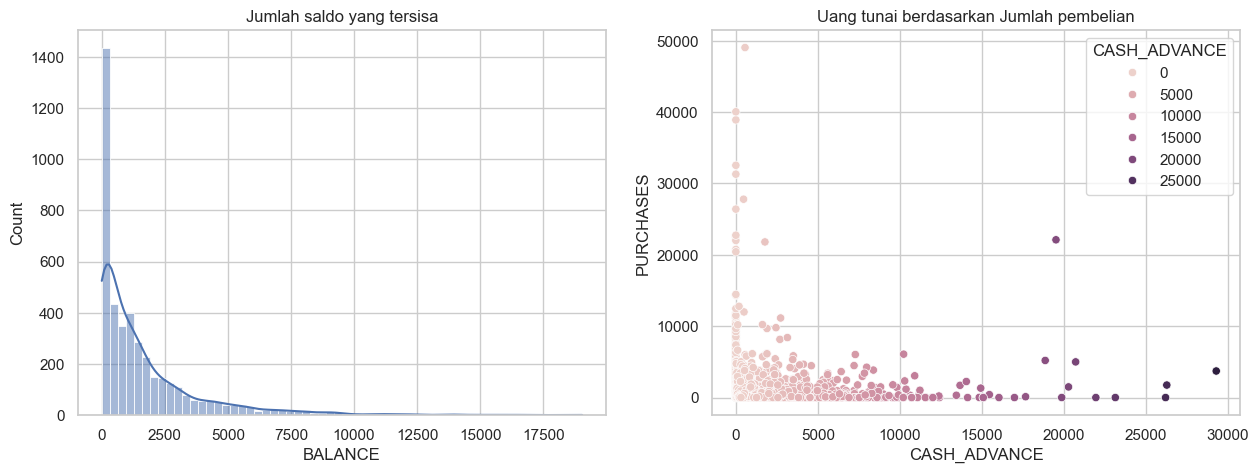

In [66]:
# Membuat Histogram dan Scatter Plot
# bikin kanvas
plt.figure(figsize=(15,5))                              #untuk bikin canvas, 15 itu panjangnya, 5 lebarnya

# Plot 1 taruh dikiri
plt.subplot(1, 2, 1)                                    #untuk bikin kolom 1 (1(untuk baris), 2(untuk kolom), 1(pilih kolom mana yang mau ditampilkan))
sns.histplot(df_1['BALANCE'],kde=True, bins=60, palette='muted')           #untuk bikin grafik, kde itu untuk bikin gari miringnya, binsnya itu banyak batangnya
plt.title('Jumlah saldo yang tersisa')                                      #judul grafik

# Plot 2 taruh dikanan
plt.subplot(1, 2, 2)                                    #untuk bikin kolom 2
sns.scatterplot(x='CASH_ADVANCE',y='PURCHASES',hue='CASH_ADVANCE',data=df_1)    #untuk bikin grafik
plt.title('Uang tunai berdasarkan Jumlah pembelian')

# tampilkan plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

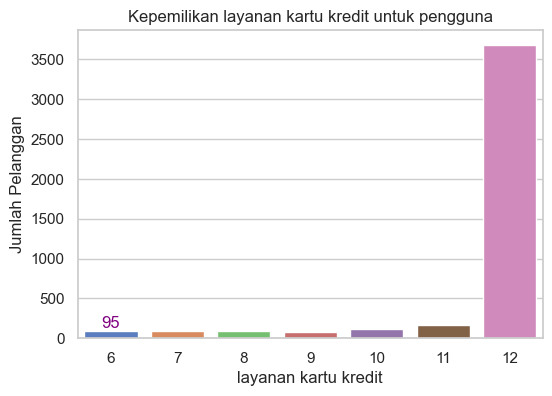

In [67]:
# Plot 3 
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=df_1["TENURE"], palette="muted")
sns.set(style="whitegrid")                                      # Opsi ini menambahkan grid pada plot
ax.bar_label(ax.containers[0], color="purple", fontsize=12)     # Menambahkan label di atas bar
plt.title("Kepemilikan layanan kartu kredit untuk pengguna")
plt.xlabel("layanan kartu kredit")                 # Mengganti ylabel menjadi xlabel
plt.ylabel("Jumlah Pelanggan")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

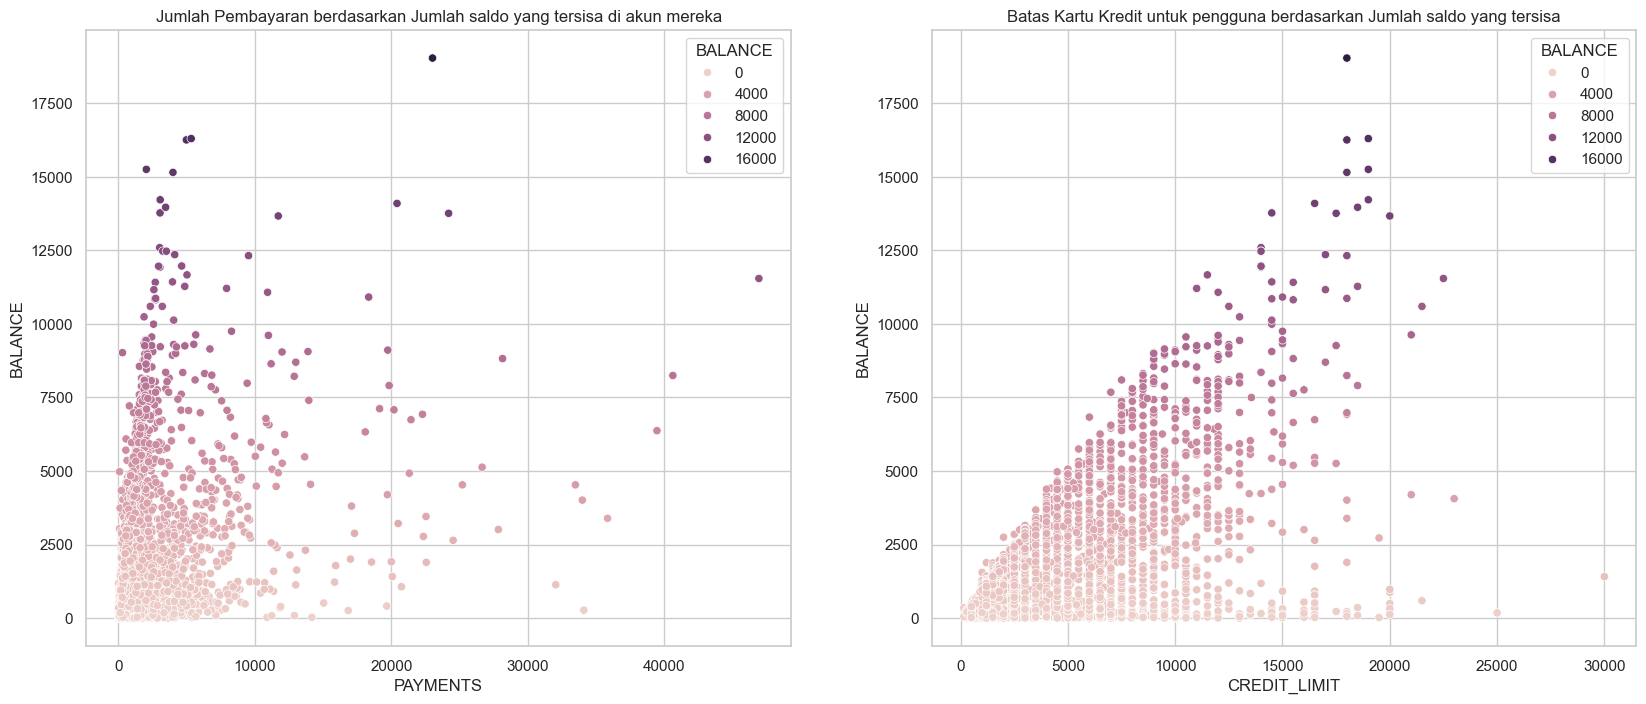

In [68]:
# Membuat Histogram dan Scatter Plot
# bikin kanvas
plt.figure(figsize=(20,8))                              #untuk bikin canvas, 15 itu panjangnya, 5 lebarnya

# Plot 4 taruh dikiri
plt.subplot(1, 2, 1)                                    #untuk bikin kolom 1 (1(untuk baris), 2(untuk kolom), 1(pilih kolom mana yang mau ditampilkan))
sns.scatterplot(x='PAYMENTS',y='BALANCE',hue='BALANCE',data=df_1)    #untuk bikin grafik
plt.title('Jumlah Pembayaran berdasarkan Jumlah saldo yang tersisa di akun mereka')                                      #judul grafik

# Plot 5 taruh dikanan
plt.subplot(1, 2, 2)                                    #untuk bikin kolom 2
sns.scatterplot(x='CREDIT_LIMIT',y='BALANCE',hue='BALANCE',data=df_1)    #untuk bikin grafik
plt.title('Batas Kartu Kredit untuk pengguna berdasarkan Jumlah saldo yang tersisa')

# tampilkan plot
plt.show

Dari hasil EDA 2 ini tidak jauh berbeda dengan EDA sebelumnya, hanya saja data yang kita gunakan di EDA 2 ini adalah data yang sudah bersih sehingga datanya tidak sebanyak yang pertama dan tidak terdapat missing value.

---

# Model Saving

Penyimpanan model (*model saving*) dan informasi terkait adalah langkah penting dalam pengembangan model-machine learning. Dengan cara menyimpan file pada pipeline, kita dapat dengan mudah menggunakan model yang telah dilatih di masa depan, berbagi model dengan orang lain, atau memuat kembali model untuk prediksi.

In [69]:
# Simpan model atau objek menggunakan pickle
with open('P1G6_file_Pipeline.pkl', 'wb') as file_1:
    pickle.dump(pipeline, file_1)

Dalam code diatas kita menggunakan library `pickle` untuk menyimpan model dan scaler. Dengan demikian, kita bisa memuat kembali model dan konfigurasi preprocessing dengan mudah untuk penggunaan berikutnya.

---

# Model Inference

Pada Model inference ini dibuat di notebook yang berbeda dengan format nama `P1G6_Set_1_jeni_kasturi_inf.ipynb`

---

# Kesimpulan

**Penjelasan Data**

Dari pengolahan data diatas dapat kita simpulkan bahwa data berisikan :
- Terdapat 18 kolom
- Bertipe Float(64) 14 kolom dan Integer(64) 4 kolom
- Memiliki 4475 baris
- Dan terdapat missing value pada `CREDIT_LIMIT` dan `MINIMUM_PAYMENTS`, jadi perlu dihandle missing valuenya.

**Hasil Eksplorasi Data**

Dari hasil analisa yang sudah kita lakukan pada dataset, kita dapat menemukan fakta bahwa :
1. Pada ***Data Loading*** : datanya termasuk skew distribution karena hasil mean dan median(50%) dari kolom `CREDIT_LIMIT` itu jauh angkanya.

2. Pada ***Exploratory Data Analysis (EDA)*** : jumlah saldo yang tersisa di akun pelanggan untuk melakukan pembelian lebih banyak yang 0. Uang tunai di muka yang diberikan oleh pengguna hanya sedikit yang yang nominal diatas 25000. Kepemilikan layanan kartu kredit bagi pengguna jauh lebih banyak yang menggunakan layanan kartu kredit 12.

3. Pada ***Feature Engineering*** : 
    - Karena terdapat 1 missing value di kolom `CREDIT_LIMIT` pada baris ke 3843 dan terdapat missing value di kolom `MINIMUM_PAYMENTS` sebanyak 158 baris, maka kita perlu melakukan handling missing value.

    - Membuat sampel data inference untuk mendrop satu baris dari keseluruhan data yang nanti akan kita jadikan bahan untuk prediksi.

    - Mengecek cardinality untuk melihat apakah datanya termasuk low cardinality atau hight cardinality, dan hasilnya data merupakan data low cardinality karena dia memiliki sedikit categorical, jadi kita tidak perlu melakukan cardinality. 

    - Menghandle outliers dengan menggunakan metode *caping* pada kolom seluruh kolom. 

    - Menvisualisasi skewed distribution menggunakan boxplot.

    - Memastikan nilai upper bound dan lower bound untuk menjaga validitas data kita, menghindari kesalahan perhitungan pada data, dan mematuhi batasan yang ada dalam konteks tertentu.

    - Melakukan remove pada kolom `Tenure` dikarenakan kolom tersebut termasuk low variant.

    - Memisahkan kolom `CUST_ID` dan `TENURE` dengan menggunakan `.drop` dikarenakan kolom tersebut termasuk categorical.

    - Setelah dilakukan analisis distribusi pada kolom numerik hasilnya adalah distribusi skew, maka kita akan menggunakan metode *MinMaxScaler*
    
    - Melakukan reduksi dimensi/pengurangan dimensi menggunakan PCA karena data kita memiliki sejumlah fitur yang sangat banyak dan ketika KMeans memanfaatkan hasil PCA, hasil clusteringnya lebih baik dibandingkan tanpa menggunakan PCA.

    - Mengurangi fitur dari 16 fitur menjadi hanya 9 fitur yang mewakili dari keseluruhan data.

4. Pada ***Model Definition*** : 
    - Menemukan Jumlah Cluster yang Optimal dengan menggunakan Metode Elbow, Plot Silhoutte & Skor Silhoutte. alasannya yaitu dengan metode Elbow membantu kita menentukan jumlah optimal kluster, Plot Silhouette membantu memvisualisasikan kualitas kluster, dan Skor Silhouette memberikan metrik numerik untuk mengukur kualitas clustering.
    
    - Menentukan pipeline dalam pengolahan data dan analisis komponen utama (PCA) yang diikuti oleh algoritma K-Means Clustering.
    
    - Melatih dengan jumlah cluster yang optimal dengan membuat *cluster_prediction*.

    - Menampilkan distribusi cluster dengan menggunakan pie chart untuk melihat berapa banyak yang terdistribusi pada setiap cluster.

    - Membuat kesimpulan dan EDA 2 untuk melihat perbandingan dataset kita.

5. Pada ***Model Saving*** : Menggunakan library `pickle` untuk menyimpan model, scaler, PCA dan KMeans dalam bentuk file biner.

6. Pada ***Model Inference*** : Kita menampilkan model yang sudah dilatih dan akan dicoba tampilkan sebagian data pada data yang merupakan format data yang asli dan bukan data yang sudah di-scaled pada halaman baru. Dan hasil yang ditampilkan adalah goodfit.

**Rekomendasi**

Rekomendasi yang dapat saya berikan kepada anda yang ingin menganalisis project ini yaitu dengan membuat penawaran khusus kepada pelanggan dalam kluster tertentu atau penyesuaian batas kartu kredit. Pastikan data selalu diperbarui, missing values diminimalkan, dan outliers ditangani secara berkala. Data yang berkualitas akan menghasilkan hasil clustering yang lebih baik. Selain K-Means, eksplorasi berbagai algoritma clustering lainnya seperti DBSCAN, Hierarchical Clustering, atau Gaussian Mixture Model (GMM) untuk melihat apakah algoritma lain mungkin lebih cocok untuk data Anda. Penting untuk memiliki pemahaman mendalam tentang domain industri kartu kredit. Ini akan membantu dalam interpretasi hasil clustering dan pengambilan keputusan yang lebih baik.

---

# Pertanyaan

1. Apakah yang dimaksud dengan inertia pada algoritma K-Means?

    *Jawab* :

    Inertia pada algoritma K-Means adalah ukuran yang mengukur sejauh apa titik data dalam suatu cluster (kelompok) dari pusat kluster (centroid) yang terkait. Itu dihitung sebagai jumlah kuadrat jarak antara setiap titik data dalam kluster dengan pusat kluster terdekat. Tujuan K-Means adalah meminimalkan inertia, yang berarti mengelompokkan data sedekat mungkin dengan pusat kluster mereka.

2. Jelaskan yang dimaksud dengan Elbow Method (alasan penggunaan, cara penggunaan, kelemahan/kelebihan, dll)!

    *Jawab* :

    - *`Alasan Penggunaan`* : Metode siku (Elbow Method) digunakan untuk menentukan jumlah kluster yang optimal dalam algoritma K-Means. Ini membantu memahami seberapa baik data dapat dikelompokkan dalam berbagai jumlah kluster.

    - *`Cara Penggunaan`* :
        - Jalankan K-Means dengan berbagai jumlah kluster yang mungkin.
        - Hitung nilai inertia (total jarak kuadrat) untuk setiap kasus.
        - Plot jumlah kluster terhadap nilai inertia.
        - Pilih jumlah kluster di mana penurunan inertia menurun drastis (seperti siku) sebagai jumlah kluster optimal.

    - *`Kelebihan`* :
        - Metode yang sederhana dan mudah dipahami.
        - Memberikan pandangan visual tentang jumlah kluster yang optimal.

    - *`Kelemahan`* :
        - Hasilnya bisa subjektif, dan penentuan "siku" bisa sulit.
        - Tidak selalu efektif jika data tidak memiliki siku yang jelas.